In [2]:
import json
from typing import List

import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt
from clip import tokenize
from transformers import CLIPVisionModelWithProjection, CLIPTextModelWithProjection, CLIPImageProcessor

from src.fashioniq_experiment.utils import element_wise_sum_original, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search_clip, \
    compute_results_fiq_val_clip
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [3]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [4]:
CLIP_NAME = 'laion/CLIP-ViT-bigG-14-laion2B-39B-b160k'

In [5]:
clip_text_encoder = CLIPTextModelWithProjection.from_pretrained(CLIP_NAME, torch_dtype=torch.float32, projection_dim=1280)
clip_text_encoder = clip_text_encoder.float().to(device)

print("clip text encoder loaded.")
clip_text_encoder.eval()

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/120k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/169M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

clip text encoder loaded.

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1280)
      (position_embedding): Embedding(77, 1280)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (layer_norm2): La

In [6]:
clip_img_encoder = CLIPVisionModelWithProjection.from_pretrained(CLIP_NAME,torch_dtype=torch.float32, projection_dim=1280)

clip_img_encoder = clip_img_encoder.float().to(device)
print("clip img encoder loaded.")
clip_img_encoder.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

clip img encoder loaded.

CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1664)
    )
    (pre_layrnorm): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-47): 48 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1664, out_features=1664, bias=True)
            (v_proj): Linear(in_features=1664, out_features=1664, bias=True)
            (q_proj): Linear(in_features=1664, out_features=1664, bias=True)
            (out_proj): Linear(in_features=1664, out_features=1664, bias=True)
          )
          (layer_norm1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1664, out_features=81

In [7]:
print('CLIP preprocess pipeline is used')
preprocess = CLIPImageProcessor(
    crop_size={'height': 224, 'width': 224},
    do_center_crop=True,
    do_convert_rgb=True,
    do_normalize=True,
    do_rescale=True,
    do_resize=True,
    image_mean=[0.48145466, 0.4578275, 0.40821073],
    image_std=[0.26862954, 0.26130258, 0.27577711],
    resample=3,
    size={'shortest_edge': 224},
)

CLIP preprocess pipeline is used

In [8]:
clip_tokenizer = tokenize

In [9]:
combining_function_original = element_wise_sum_original

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [11]:
with open('../../../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 74357

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [12]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'shirt',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
display(shirt_recall_at10, shirt_recall_at50)

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   14.573111  15.112856  15.701668  16.388616  16.928361  17.713444   
0.05   14.916585  15.407263  15.947007  16.339548  16.879293  18.204121   
0.10   15.161924  15.652600  16.143277  16.633955  17.369971  17.958783   
0.15   14.867517  15.456329  16.094211  16.486752  17.419039  18.302257   
0.20   14.229637  14.965652  15.603533  16.486752  17.124632  18.400392   
0.25   14.131501  14.720315  15.456329  16.290481  17.271835  17.909716   
0.30   13.346419  14.033367  14.916585  15.358195  16.388616  17.369971   
0.35   12.855741  13.640824  14.278704  15.014720  16.094211  16.830225   
0.40   12.414131  13.150147  13.738960  14.573111  15.309127  16.143277   
0.45   11.383709  11.923455  12.757605  13.837095  14.573111  15.701668   
0.50   11.040235  11.530913  12.217861  13.002944  14.131501  14.965652   
0.55   10.500491  11.089303  11.629048  12.021590  13.493621  14.474976   
0.60   10.009813  10.500491  11.040235  11.432777  12.904808  13.837095   
0.65    9.273798   9.960746  10.402355  10.843965  11.629048  13.002944   
0.70    8.783121   9.175663   9.568204  10.107949  10.991168  11.923455   
0.75    7.998037   8.390579   8.881256   9.421001  10.157017  10.893033   
0.80    7.850834   8.194308   8.635917   8.979391   9.666339  10.549559   
0.85    7.556428   7.850834   8.439647   8.684985   9.028459   9.568204   
0.90    7.163886   7.409225   7.899902   8.145241   8.537782   8.881256   
0.95    6.526006   6.771345   7.311089   7.654563   7.948969   8.488715   
1.00    6.182532   6.378803   6.476938   7.065751   7.409225   7.998037   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   18.940137  20.117763  21.687929  23.650637  ...  28.508341  31.108931   
0.05   19.528949  20.363101  22.031404  24.043180  ...  29.293424  31.697744   
0.10   19.725221  20.902845  22.473013  24.631992  ...  29.391560  32.041216   
0.15   19.872424  21.246320  23.012757  24.631992  ...  29.636899  32.237488   
0.20   19.479883  21.491659  23.061825  24.631992  ...  29.833171  32.875368   
0.25   19.283612  21.050049  23.012757  24.730128  ...  29.784101  32.826301   
0.30   18.743867  20.412169  22.620216  24.484789  ...  29.489696  32.531893   
0.35   17.615309  19.479883  22.129539  24.239451  ...  29.489696  32.237488   
0.40   17.075564  18.842001  20.755643  23.258096  ...  28.999019  31.501472   
0.45   17.075564  18.007851  19.774288  22.522080  ...  28.508341  31.059861   
0.50   16.045143  17.468105  19.430815  21.540727  ...  27.674189  29.735035   
0.55   15.799804  16.977429  18.547596  20.608440  ...  26.251227  29.048085   
0.60   15.112856  16.388616  17.369971  19.381747  ...  25.171736  27.428851   
0.65   14.229637  15.210991  16.683023  18.596664  ...  23.699705  26.104024   
0.70   12.904808  14.229637  15.358195  17.320903  ...  22.129539  24.828263   
0.75   12.168793  13.493621  14.622179  16.388616  ...  20.853779  22.963689   
0.80   11.481845  12.512267  13.837095  15.848872  ...  20.264965  21.982336   
0.85   10.549559  11.678116  12.904808  14.622179  ...  18.743867  20.264965   
0.90    9.911678  10.843965  12.266929  13.984299  ...  17.369971  19.038273   
0.95    9.224730   9.911678  11.383709  13.101080  ...  16.241413  18.056919   
1.00    8.635917   9.175663  10.598626  12.021590  ...  15.112856  16.486752   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   34.052992  36.359176  37.389597  37.095192  35.426888  31.746811   
0.05   34.347400  36.604515  38.125613  37.978411  35.770363  32.728165   
0.10   34.543669  36.849853  38.223749  37.733072  36.310107  32.973504   
0.15   34.936211  37.340531  38.272816  37.782139  35.8684

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   26.987243  27.870461  28.851816  30.029440  31.207067  32.826301   
0.05   27.281648  27.968597  29.146221  30.520117  31.746811  32.875368   
0.10   27.379784  28.066733  29.195291  30.471051  31.697744  33.120707   
0.15   27.134445  28.066733  29.048085  30.421981  31.746811  32.973504   
0.20   26.889107  27.821395  28.802747  30.029440  31.010795  32.728165   
0.25   26.545632  26.938176  28.164867  29.538763  31.010795  32.482827   
0.30   26.054955  26.790971  27.723259  29.048085  30.421981  31.844947   
0.35   25.318941  26.202160  27.232581  28.459275  30.127576  31.403336   
0.40   24.631992  25.515211  26.545632  27.674189  29.342493  30.961728   
0.45   24.141315  25.122669  25.907752  26.938176  28.459275  29.980373   
0.50   23.356232  24.288519  24.877331  26.005888  27.379784  29.342493   
0.55   22.031404  23.159961  23.797841  24.877331  26.447499  28.017664   
0.60   20.804711  21.884200  22.816487  24.092247  25.073603  26.741904   
0.65   19.528949  20.412169  21.491659  22.718351  23.895976  25.269872   
0.70   18.547596  19.528949  20.461236  21.393523  22.571148  23.846909   
0.75   17.320903  18.007851  19.332679  20.412169  21.540727  22.325809   
0.80   16.192345  16.781157  17.664377  19.234544  20.117763  21.442591   
0.85   15.161924  15.701668  16.535820  17.124632  18.547596  19.676153   
0.90   14.180569  14.671247  15.603533  16.437684  17.566241  18.645731   
0.95   13.444553  13.689892  14.474976  15.260059  16.241413  17.615309   
1.00   12.659471  13.101080  13.837095  14.425908  15.210991  16.437684   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   34.445536  36.408243  38.518155  40.088323  ...  45.093229  46.957803   
0.05   34.789008  36.604515  39.156035  40.628067  ...  45.534837  47.890088   
0.10   34.789008  36.849853  39.254171  41.020608  ...  46.074584  48.577037   
0.15   34.887144  37.095192  39.254171  41.413149  ...  46.810597  49.067715   
0.20   34.985280  37.046123  38.959765  41.609421  ...  47.644749  49.754661   
0.25   34.347400  37.193328  39.057899  41.609421  ...  47.595683  49.950933   
0.30   33.807653  36.457312  38.910696  41.805691  ...  47.546613  50.196272   
0.35   33.562315  35.868499  38.714427  41.413149  ...  47.350344  49.214917   
0.40   33.071640  35.672227  38.125613  40.775269  ...  46.467125  48.527968   
0.45   32.335624  35.132483  37.585869  40.333661  ...  45.632973  47.791952   
0.50   31.452405  34.396467  37.095192  40.186456  ...  44.651619  47.154072   
0.55   30.225712  32.777232  35.819432  38.812563  ...  43.866536  45.976448   
0.60   28.508341  31.157997  33.954859  37.291461  ...  43.032384  45.240432   
0.65   27.232581  29.440629  32.482827  35.377821  ...  42.149165  44.210011   
0.70   25.760549  28.017664  30.667320  33.611384  ...  40.333661  42.688912   
0.75   24.239451  26.153091  28.851816  32.041216  ...  38.812563  41.069677   
0.80   23.061825  24.779195  27.085379  29.784101  ...  36.800784  38.812563   
0.85   21.442591  23.503435  25.564280  28.312069  ...  34.298331  36.555445   
0.90   20.363101  22.522080  24.288519  26.447499  ...  32.237488  34.396467   
0.95   18.940137  20.804711  22.914623  25.466144  ...  30.176643  32.875368   
1.00   18.056919  19.234544  21.540727  23.846909  ...  28.606477  30.618253   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   49.411187  52.011776  54.072618  55.201179  53.532875  49.263984   
0.05   50.588810  53.042197  55.348378  55.888128  54.072618  49.852797   
0.10   51.226693  53.483808  55.986261  56.182534  54.219824  49.950933   
0.15   52.011776  53.974485  56.084394  55.937195  53.3856

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'dress',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25       0.30  \
beta                                                                           
0.00   7.040159  7.387209  7.783838  8.527516  8.973724  9.469509  10.659395   
0.05   6.841844  7.436787  7.684680  8.329201  8.924145  9.766981  10.659395   
0.10   6.693108  7.139315  7.635102  8.130887  8.824988  9.667823  10.857709   
0.15   6.494794  6.693108  7.288051  7.833416  8.775409  9.469509  10.411502   
0.20   6.544373  6.891423  7.436787  7.833416  8.329201  9.172038  10.312345   
0.25   6.544373  6.742688  6.990580  7.337630  8.081309  8.824988   9.766981   
0.30   6.246901  6.445216  6.693108  7.089737  7.486366  8.428359   9.072880   
0.35   5.552801  6.098166  6.395637  6.891423  7.139315  7.783838   8.973724   
0.40   5.404066  5.552801  6.147744  6.494794  6.941001  7.387209   8.378781   
0.45   5.106594  5.404066  5.552801  6.048587  6.742688  7.288051   8.031730   
0.50   4.610808  4.858701  5.304908  5.701537  6.048587  6.841844   7.585523   
0.55   4.412494  4.660387  4.858701  5.304908  5.800694  6.395637   7.089737   
0.60   4.164601  4.362915  4.412494  5.057015  5.701537  5.999009   6.643530   
0.65   3.867129  4.065444  4.214180  4.511651  5.354487  5.850273   6.296480   
0.70   3.520079  3.619236  3.916708  4.015865  4.511651  5.156172   5.453644   
0.75   3.173029  3.272187  3.668815  3.767972  4.164601  4.709965   5.106594   
0.80   2.825979  2.974715  3.173029  3.321765  3.569658  4.115022   4.610808   
0.85   2.677243  2.776401  2.825979  2.825979  3.123451  3.520079   3.916708   
0.90   2.478929  2.528508  2.627665  2.875558  2.875558  3.173029   3.668815   
0.95   2.330193  2.379772  2.478929  2.578086  2.776401  3.024293   3.272187   
1.00   2.082300  2.181458  2.181458  2.181458  2.231036  2.578086   2.875558   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00   11.799703  13.435796  14.972731  ...  19.831432  22.607833  25.185919   
0.05   12.245910  13.534953  15.270203  ...  20.128904  23.351513  26.375806   
0.10   12.097174  13.485375  15.220624  ...  20.178483  23.797719  26.574120   
0.15   11.849281  13.187903  14.774418  ...  20.376797  23.748142  26.970750   
0.20   11.403074  12.840852  14.576103  ...  19.930591  23.500247  26.623699   
0.25   10.758552  12.295488  14.675260  ...  19.682696  23.103619  25.632128   
0.30   10.411502  11.898860  13.882002  ...  19.682696  22.359940  24.789292   
0.35   10.064452  11.551809  12.989588  ...  18.393654  21.566683  23.648983   
0.40    9.717402  11.056024  12.295488  ...  17.649975  20.475954  22.359940   
0.45    9.271195  10.510659  11.799703  ...  16.807139  19.484383  21.269211   
0.50    8.577095  10.114031  11.353495  ...  15.964304  18.195340  20.228061   
0.55    7.783838   9.370352  10.659395  ...  15.121467  17.154190  18.443233   
0.60    7.337630   8.477937  10.014874  ...  13.832425  15.765989  17.451660   
0.65    6.841844   7.982152   9.172038  ...  12.791274  14.328210  15.617253   
0.70    6.494794   7.387209   8.527516  ...  11.998017  13.485375  14.526525   
0.75    5.850273   6.445216   7.387209  ...  10.907288  12.592959  13.386217   
0.80    5.057015   5.800694   6.494794  ...  10.163610  11.601388  11.898860   
0.85    4.115022   5.156172   5.999009  ...   8.824988  10.312345  10.609817   
0.90    4.065444   4.660387   5.304908  ...   7.486366   8.973724   9.766981   
0.95    3.619236   4.164601   4.610808  ...   6.693108   8.130887   8.874566   
1.00    3.073872   3.767972   4.164601  ...   5.751115   7.089737   7.932573   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   28.358948  30.441248  30.937034  28.507686  25.285077  21.021318   
0.05   28.606841  30.490828  30.937034  29.152206  25.780863  21.021318   
0.10   29.201785  

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   18.790282  19.831432  20.575112  21.219634  22.558255  23.698562   
0.05   18.542390  19.335647  20.178483  21.021318  22.211204  23.301934   
0.10   17.848289  18.790282  19.781855  21.120475  22.062469  23.252355   
0.15   17.649975  18.294497  19.980168  21.120475  22.459097  23.351513   
0.20   17.302924  18.244918  19.186911  20.624690  21.814576  23.153198   
0.25   17.402083  17.997025  19.137333  19.930591  21.417947  22.756569   
0.30   16.707982  17.402083  18.294497  19.087754  20.872582  22.706990   
0.35   15.765989  16.559246  17.451660  18.344076  19.633119  21.566683   
0.40   14.625682  15.518096  16.509669  17.203768  18.691126  20.079325   
0.45   13.882002  14.377789  15.319782  16.311353  17.699553  18.889439   
0.50   12.642539  13.336639  14.080317  15.270203  16.261774  17.798711   
0.55   11.650967  12.394646  12.989588  14.229053  15.071888  16.410510   
0.60   11.204760  11.601388  12.146752  13.138324  14.427367  15.468517   
0.65   10.411502  10.907288  11.105602  11.898860  13.138324  14.278631   
0.70    9.866138  10.312345  10.808131  11.204760  11.849281  13.237481   
0.75    9.072880   9.618245  10.064452  10.461081  11.155181  12.196331   
0.80    8.279623   8.874566   9.320773   9.866138  10.609817  11.403074   
0.85    7.734258   8.180466   8.676252   9.172038   9.816559  10.510659   
0.90    7.139315   7.585523   8.230045   8.577095   9.221616   9.816559   
0.95    6.593952   6.891423   7.089737   7.635102   8.279623   9.023302   
1.00    6.147744   6.544373   6.841844   7.139315   7.436787   7.932573   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   25.185919  27.317798  30.193356  32.870600  ...  39.414972  42.637581   
0.05   25.185919  27.664849  30.490828  33.366385  ...  39.960337  42.736739   
0.10   25.086764  27.565691  30.441248  33.019337  ...  40.158650  43.480417   
0.15   25.037184  27.516112  30.292514  33.068913  ...  40.208229  43.083787   
0.20   24.938026  27.416956  30.342093  33.515123  ...  39.811602  42.637581   
0.25   24.590977  27.069905  29.697570  32.870600  ...  39.018345  41.745165   
0.30   24.491820  26.177493  29.152206  32.176501  ...  38.968766  41.298959   
0.35   23.103619  25.384235  27.764004  31.135350  ...  37.778878  40.307388   
0.40   21.963312  24.392663  26.871592  29.747149  ...  36.688152  39.117500   
0.45   21.120475  23.054041  25.582549  28.408527  ...  35.101637  37.481409   
0.50   19.583540  21.665840  24.144769  27.069905  ...  33.267230  35.845315   
0.55   18.344076  20.079325  22.607833  25.285077  ...  31.730291  34.159642   
0.60   17.352504  19.137333  21.120475  23.500247  ...  29.350519  31.879029   
0.65   15.765989  17.451660  19.385226  21.417947  ...  27.466536  29.945463   
0.70   14.377789  16.013882  17.897868  19.881012  ...  25.433812  27.912742   
0.75   13.138324  14.675260  16.658403  18.939018  ...  23.549826  25.830442   
0.80   12.196331  13.435796  15.270203  17.501239  ...  21.913733  23.450670   
0.85   11.303917  12.444224  14.080317  16.013882  ...  19.881012  21.963312   
0.90   10.808131  11.650967  12.989588  14.724839  ...  18.443233  20.327219   
0.95    9.866138  10.758552  11.998017  13.287060  ...  16.955875  18.443233   
1.00    8.824988   9.816559  11.056024  12.047596  ...  15.369360  16.757561   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   46.405554  49.529004  52.057511  52.107090  50.520575  45.562717   
0.05   46.405554  49.975210  52.007931  52.454138  51.065940  46.405554   
0.10   46.157661  50.024790  52.057511  52.454138  51.115519  46.802181   
0.15   45.959345  49.826476  51.859194  51.809621  49.7768

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [16]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'toptee',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
display(toptee_recall_at10, toptee_recall_at50)

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   10.657828  11.524732  12.034676  13.003570  14.227435  14.941357   
0.05   10.504845  11.065783  11.728710  12.799592  13.615502  15.094340   
0.10   10.249873  10.708822  11.269760  12.289649  13.717490  14.788373   
0.15   10.402856  10.657828  11.473738  12.085670  13.768485  15.094340   
0.20   10.198878  10.810811  11.728710  12.391637  13.666497  15.094340   
0.25    9.892911  10.759816  11.320755  12.187659  13.360530  14.635390   
0.30    9.637940  10.402856  11.167771  11.830699  13.054565  14.074452   
0.35    9.127996   9.688934  10.912800  11.575726  12.442631  13.462520   
0.40    8.516064   9.382968  10.198878  11.065783  12.034676  12.952575   
0.45    8.312086   8.720041   9.688934  10.351861  11.524732  12.544620   
0.50    7.700153   8.363080   9.026007   9.790923  10.759816  11.932687   
0.55    6.782254   7.394186   8.108108   9.280979   9.943906  11.473738   
0.60    6.374299   6.782254   7.649159   8.567058   9.229985  10.504845   
0.65    5.864355   6.323305   7.088220   8.057114   8.363080   9.484956   
0.70    5.405406   5.711372   6.272310   7.190209   7.751147   8.567058   
0.75    4.997450   5.354411   5.864355   6.629271   7.292198   8.210097   
0.80    4.538501   4.793473   5.405406   6.272310   6.629271   7.547170   
0.85    4.334523   4.538501   5.150434   5.507394   6.272310   7.088220   
0.90    4.232534   4.283529   4.691484   5.456400   6.068332   6.782254   
0.95    3.722591   3.977562   4.283529   5.150434   5.354411   6.527282   
1.00    3.467619   3.824579   3.875574   4.436512   5.048444   5.711372   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   16.114227  17.746048  19.785823  22.386537  ...  28.250891  32.126465   
0.05   16.165222  18.204997  20.142785  22.437532  ...  28.760836  32.840389   
0.10   16.369200  18.154003  20.193778  22.590515  ...  29.219785  33.452320   
0.15   16.624172  18.357980  20.499745  23.151453  ...  29.117796  33.503315   
0.20   16.420195  18.154003  20.652728  23.100460  ...  29.270780  33.503315   
0.25   15.604283  17.899030  20.040795  22.947475  ...  28.607854  32.534420   
0.30   15.349312  17.542070  19.785823  22.233555  ...  28.250891  32.075471   
0.35   15.043345  17.032127  18.816930  22.029577  ...  27.944925  31.718510   
0.40   14.278430  16.726160  18.561958  21.366650  ...  27.231005  31.310555   
0.45   13.768485  15.910250  18.255992  20.193778  ...  26.925039  30.647629   
0.50   13.258542  15.247323  17.389087  20.091790  ...  26.262110  29.474759   
0.55   12.697603  14.431413  16.726160  19.071902  ...  25.701174  28.301886   
0.60   12.136665  13.309535  15.247323  18.052015  ...  24.324325  27.027026   
0.65   10.810811  12.442631  14.176440  16.522183  ...  23.100460  25.395206   
0.70    9.892911  11.422744  13.462520  15.451300  ...  22.080570  24.375318   
0.75    9.229985  10.657828  13.054565  14.635390  ...  20.346762  23.049465   
0.80    8.465069   9.841917  12.136665  13.717490  ...  18.969913  21.162672   
0.85    8.159102   9.280979  11.371749  13.105558  ...  17.746048  19.530852   
0.90    7.598164   8.669046  10.453850  12.085670  ...  16.522183  17.899030   
0.95    7.037226   8.363080   9.943906  11.269760  ...  15.196328  16.471188   
1.00    6.629271   7.598164   9.026007  10.402856  ...  14.023457  15.349312   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   36.155024  39.061704  41.152474  41.917390  40.183580  37.225905   
0.05   36.919940  39.673635  41.968384  42.274350  40.438551  36.511984   
0.10   37.174910  40.234575  41.866395  42.376339  40.438551  36.511984   
0.15   37.786844  40.795511  41.866395  42.019379  39.3676

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   23.202448  24.222335  25.701174  27.129015  28.505865  30.290669   
0.05   23.610403  24.630290  25.752166  26.925039  28.301886  30.341661   
0.10   23.457420  24.732280  25.548190  26.568079  28.250891  30.239674   
0.15   23.457420  24.273330  25.497195  26.160121  27.944925  29.933706   
0.20   22.590515  23.712392  24.783275  26.364100  27.689955  29.372770   
0.25   22.284548  23.355430  24.579297  26.007140  27.231005  29.270780   
0.30   21.519633  22.437532  23.865375  25.344211  26.721060  29.117796   
0.35   20.805712  21.621622  23.151453  24.477307  26.262110  28.760836   
0.40   20.142785  21.060683  22.437532  23.814380  25.599185  27.842936   
0.45   19.428863  20.601735  21.570627  23.202448  24.936257  26.619071   
0.50   18.408975  19.479857  20.550740  22.080570  23.916370  25.803161   
0.55   17.746048  18.408975  19.734830  20.856705  23.151453  24.783275   
0.60   16.624172  18.001020  18.612953  19.785823  21.927588  23.406425   
0.65   15.349312  16.420195  17.644060  18.816930  20.754717  22.590515   
0.70   14.380418  15.298317  16.267210  17.338093  19.428863  21.315655   
0.75   13.921468  14.176440  15.145335  16.369200  18.103008  20.040795   
0.80   13.156553  13.768485  14.482407  15.349312  16.777155  18.408975   
0.85   12.289649  13.105558  13.819480  14.686385  15.859255  17.185110   
0.90   11.575726  12.238654  13.054565  14.176440  15.451300  16.573177   
0.95   10.810811  11.626721  12.238654  13.156553  14.227435  15.604283   
1.00   10.402856  10.963794  11.575726  12.238654  13.564508  14.533402   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   32.075471  34.268230  37.123916  40.285569  ...  48.444670  52.881181   
0.05   32.585415  34.931159  37.582865  41.305456  ...  50.025499  53.238142   
0.10   32.840389  35.237125  38.041815  41.968384  ...  50.637430  54.054052   
0.15   32.738400  35.543090  38.755736  43.141255  ...  51.045388  54.309028   
0.20   32.585415  35.186130  39.316675  42.784294  ...  51.198369  54.513001   
0.25   32.075471  34.982151  39.010710  42.427334  ...  51.096380  54.309028   
0.30   31.820500  34.319225  38.296786  41.968384  ...  50.994390  54.462010   
0.35   31.259561  34.319225  37.582865  41.458440  ...  50.280470  53.952068   
0.40   30.902600  33.452320  36.664966  40.693524  ...  49.515554  52.830189   
0.45   29.270780  32.585415  35.390106  39.928609  ...  47.781745  50.739419   
0.50   28.352880  31.361550  34.421214  38.755736  ...  45.843956  49.311575   
0.55   27.282000  30.035695  33.350331  37.378889  ...  44.671085  47.934726   
0.60   26.109129  28.556859  32.024476  35.900050  ...  42.631310  45.894951   
0.65   24.681285  27.383989  30.290669  34.370220  ...  40.948495  44.110149   
0.70   23.763385  26.109129  29.270780  32.636410  ...  39.571646  42.529321   
0.75   22.488527  25.038245  27.791944  31.004590  ...  37.837839  40.285569   
0.80   20.805712  23.712392  26.262110  29.780725  ...  35.849056  38.194799   
0.85   19.275880  21.978582  24.528302  27.740949  ...  34.370220  36.409995   
0.90   18.306985  20.601735  23.049465  26.109129  ...  32.585415  34.574196   
0.95   17.083120  19.122897  21.417645  24.222335  ...  30.443650  32.738400   
1.00   16.063233  17.797042  20.193778  22.794493  ...  28.811830  30.902600   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   55.583888  59.357470  61.601222  62.468129  60.683322  57.317698   
0.05   57.011729  60.326362  62.468129  63.131058  61.499238  57.980621   
0.10   57.827640  60.887301  62.723100  63.233042  61.550230  58.439571   
0.15   58.031619  60.938299  62.519121  63.080060  60.8873

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [18]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [19]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   10.757032  11.341599  11.840061  12.639901  13.376507  14.041437   
0.05   10.754425  11.303278  11.786799  12.489447  13.139647  14.355147   
0.10   10.701635  11.166913  11.682713  12.351497  13.304150  14.138326   
0.15   10.588389  10.935755  11.618667  12.135279  13.320978  14.288702   
0.20   10.324296  10.889295  11.589677  12.237268  13.040110  14.222257   
0.25   10.189595  10.740940  11.255888  11.938590  12.904558  13.790031   
0.30    9.743753  10.293813  10.925822  11.426210  12.309849  13.290927   
0.35    9.178846   9.809308  10.529047  11.160623  11.892052  12.692194   
0.40    8.778087   9.361972  10.028527  10.711229  11.428268  12.161020   
0.45    8.267463   8.682520   9.333113  10.079181  10.946844  11.844780   
0.50    7.783732   8.250898   8.849592   9.498468  10.313302  11.246728   
0.55    7.231746   7.714625   8.198619   8.869159   9.746074  10.781450   
0.60    6.849571   7.215220   7.700629   8.352283   9.278777  10.113649   
0.65    6.335094   6.783165   7.234918   7.804243   8.448872   9.446058   
0.70    5.902869   6.168757   6.585741   7.104674   7.751322   8.548895   
0.75    5.389506   5.672392   6.138142   6.606081   7.204605   7.937698   
0.80    5.071771   5.320832   5.738117   6.191155   6.621756   7.403917   
0.85    4.856065   5.055245   5.472020   5.672786   6.141407   6.725501   
0.90    4.625116   4.740420   5.073017   5.492399   5.827224   6.278846   
0.95    4.192930   4.376226   4.691182   5.127694   5.359927   6.013430   
1.00    3.910817   4.128280   4.177990   4.561240   4.896235   5.429165   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   15.237920  16.554504  18.303183  20.336635  ...  25.530222  28.614410   
0.05   15.451189  16.938003  18.569714  20.583639  ...  26.061055  29.296549   
0.10   15.650710  17.051341  18.717389  20.814377  ...  26.263276  29.763752   
0.15   15.636033  17.151194  18.900135  20.852621  ...  26.377164  29.829648   
0.20   15.404141  17.016245  18.851802  20.769518  ...  26.344847  29.959643   
0.25   14.884959  16.569211  18.449680  20.784288  ...  26.024884  29.488114   
0.30   14.388686  16.121914  18.101633  20.200115  ...  25.807761  28.989101   
0.35   13.877459  15.525487  17.499426  19.752872  ...  25.276092  28.507560   
0.40   13.244258  15.095188  16.791208  18.973411  ...  24.626666  27.762660   
0.45   12.958593  14.396432  16.180313  18.171854  ...  24.080173  27.063958   
0.50   12.296403  13.764174  15.644644  17.662004  ...  23.300201  25.801711   
0.55   11.862381  13.064227  14.881369  16.779913  ...  22.357956  24.834720   
0.60   11.297684  12.345260  13.698410  15.816212  ...  21.109495  23.407288   
0.65   10.445643  11.498489  12.947205  14.763628  ...  19.863813  21.942480   
0.70    9.417121  10.715725  12.069308  13.766573  ...  18.736042  20.896319   
0.75    8.835124  10.000574  11.373986  12.803738  ...  17.369276  19.535371   
0.80    8.185907   9.137066  10.591485  12.020386  ...  16.466163  18.248799   
0.85    7.541790   8.358039   9.810910  11.242248  ...  15.104967  16.702721   
0.90    7.059552   7.859485   9.127055  10.458292  ...  13.792840  15.303676   
0.95    6.511381   7.297998   8.497405   9.660549  ...  12.710283  14.219665   
1.00    6.046915   6.615900   7.797535   8.863016  ...  11.629143  12.975267   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   31.797978  34.593276  36.327773  36.649872  34.706051  31.419264   
0.05   32.547715  34.961664  36.861608  37.063265  35.120373  31.673671   
0.10   32.764233  35.428738  36.777693  37.032008  35.168079  31.656293   
0.15   33.231268  35.812328  36.744470  36.648431  34.5317

In [20]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   22.993324  23.974743  25.042701  26.126030  27.423729  28.938511   
0.05   23.144813  23.978178  25.025624  26.155492  27.419967  28.839654   
0.10   22.895164  23.863099  24.841778  26.053202  27.337035  28.870912   
0.15   22.747280  23.544853  24.841816  25.900859  27.383611  28.752908   
0.20   22.260849  23.259568  24.257644  25.672743  26.838442  28.418044   
0.25   22.077421  22.763544  23.960499  25.158831  26.553249  28.170059   
0.30   21.427523  22.210195  23.294377  24.493350  26.005208  27.889911   
0.35   20.630214  21.461009  22.611898  23.760219  25.340935  27.243618   
0.40   19.800153  20.697997  21.830944  22.897446  24.544268  26.294663   
0.45   19.150726  20.034064  20.932721  22.150659  23.698362  25.162961   
0.50   18.135915  19.035005  19.836129  21.118887  22.519309  24.314788   
0.55   17.142806  17.987861  18.840753  19.987696  21.556947  23.070483   
0.60   16.211214  17.162203  17.858731  19.005465  20.476186  21.872282   
0.65   15.096588  15.913217  16.747107  17.811380  19.263006  20.713006   
0.70   14.264717  15.046537  15.845526  16.645458  17.949764  19.466682   
0.75   13.438417  13.934179  14.847488  15.747483  16.932972  18.187645   
0.80   12.542840  13.141403  13.822519  14.816665  15.834911  17.084880   
0.85   11.728610  12.329231  13.010517  13.661018  14.741137  15.790641   
0.90   10.965204  11.498475  12.296048  13.063740  14.079719  15.011822   
0.95   10.283105  10.736012  11.267789  12.017238  12.916157  14.080965   
1.00    9.736690  10.203082  10.751555  11.267959  12.070762  12.967886   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   30.568975  32.664757  35.278475  37.748164  ...  44.317624  47.492188   
0.05   30.853447  33.066841  35.743243  38.433302  ...  45.173558  47.954989   
0.10   30.905387  33.217556  35.912411  38.669443  ...  45.623555  48.703835   
0.15   30.887576  33.384798  36.100807  39.207772  ...  46.021405  48.820177   
0.20   30.836240  33.216403  36.206178  39.302946  ...  46.218240  48.968414   
0.25   30.337949  33.081795  35.922059  38.969118  ...  45.903469  48.668376   
0.30   30.039991  32.318010  35.453229  38.650192  ...  45.836590  48.652413   
0.35   29.308498  31.857320  34.687099  38.002313  ...  45.136564  47.824791   
0.40   28.645851  31.172403  33.887390  37.071981  ...  44.223611  46.825219   
0.45   27.575626  30.257313  32.852841  36.223599  ...  42.838785  45.337594   
0.50   26.462942  29.141286  31.887058  35.337366  ...  41.254268  44.103654   
0.55   25.283929  27.630751  30.592532  33.825510  ...  40.089304  42.690272   
0.60   23.989991  26.284063  29.033270  32.230586  ...  38.338071  41.004804   
0.65   22.559952  24.758760  27.386241  30.388663  ...  36.854732  39.421874   
0.70   21.300575  23.380225  25.945323  28.709602  ...  35.113040  37.710325   
0.75   19.955434  21.955532  24.434054  27.328275  ...  33.400076  35.728563   
0.80   18.687956  20.642461  22.872564  25.688688  ...  31.521191  33.486011   
0.85   17.340796  19.308747  21.390967  24.022300  ...  29.516521  31.642917   
0.90   16.492739  18.258260  20.109191  22.427156  ...  27.755379  29.765961   
0.95   15.296465  16.895387  18.776761  20.991846  ...  25.858723  28.019000   
1.00   14.315046  15.616049  17.596843  19.562999  ...  24.262556  26.092805   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   50.466876  53.632750  55.910450  56.592133  54.912257  50.714800   
0.05   51.335365  54.447923  56.608146  57.157775  55.545932  51.412991   
0.10   51.737331  54.798633  56.922291  57.289904  55.628524  51.730895   
0.15   52.000913  54.913087  56.820903  56.942292  54.6832

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [21]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

/tmp/ipykernel_1638/3408074174.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

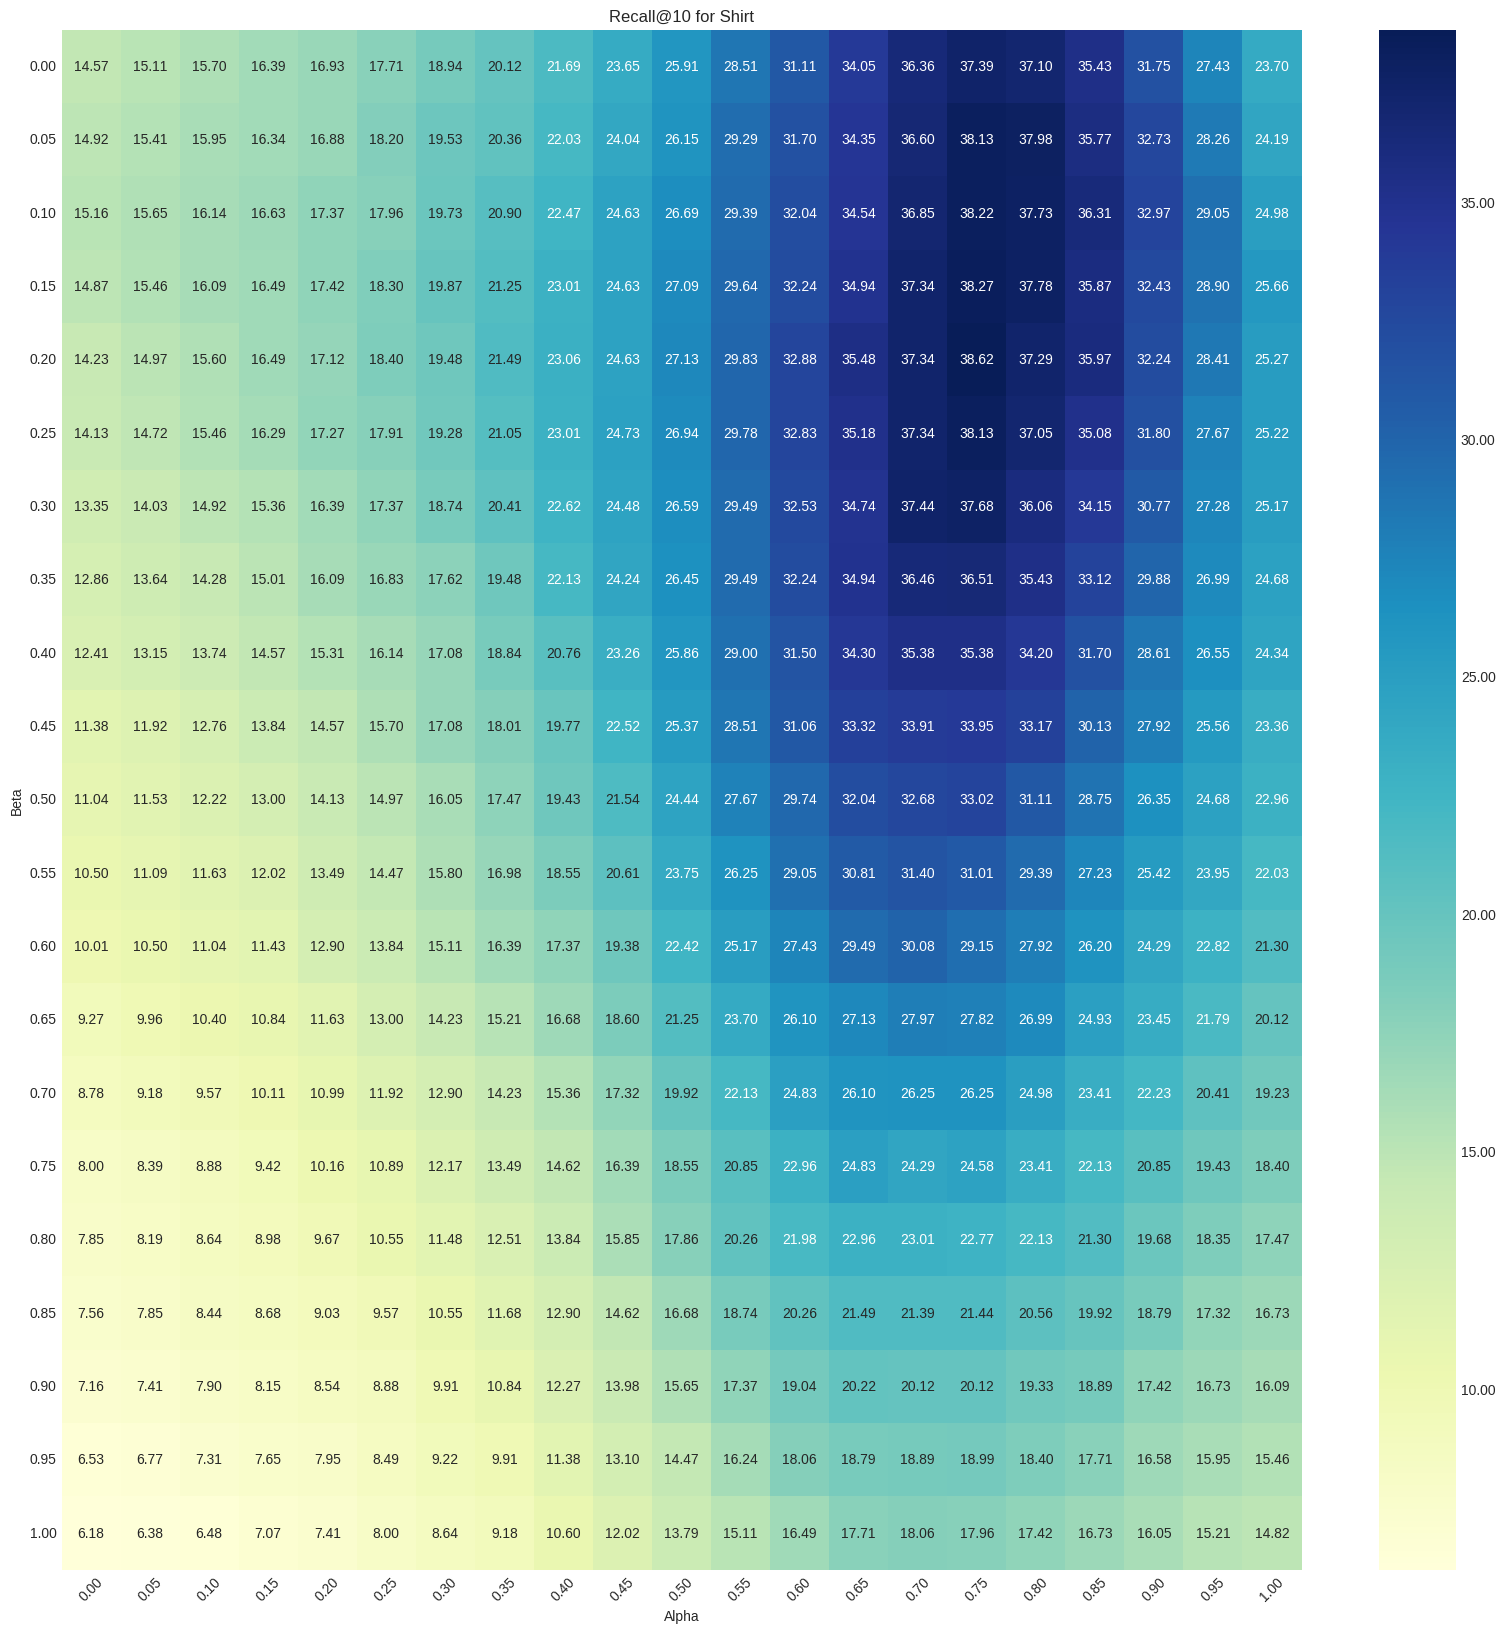

In [22]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

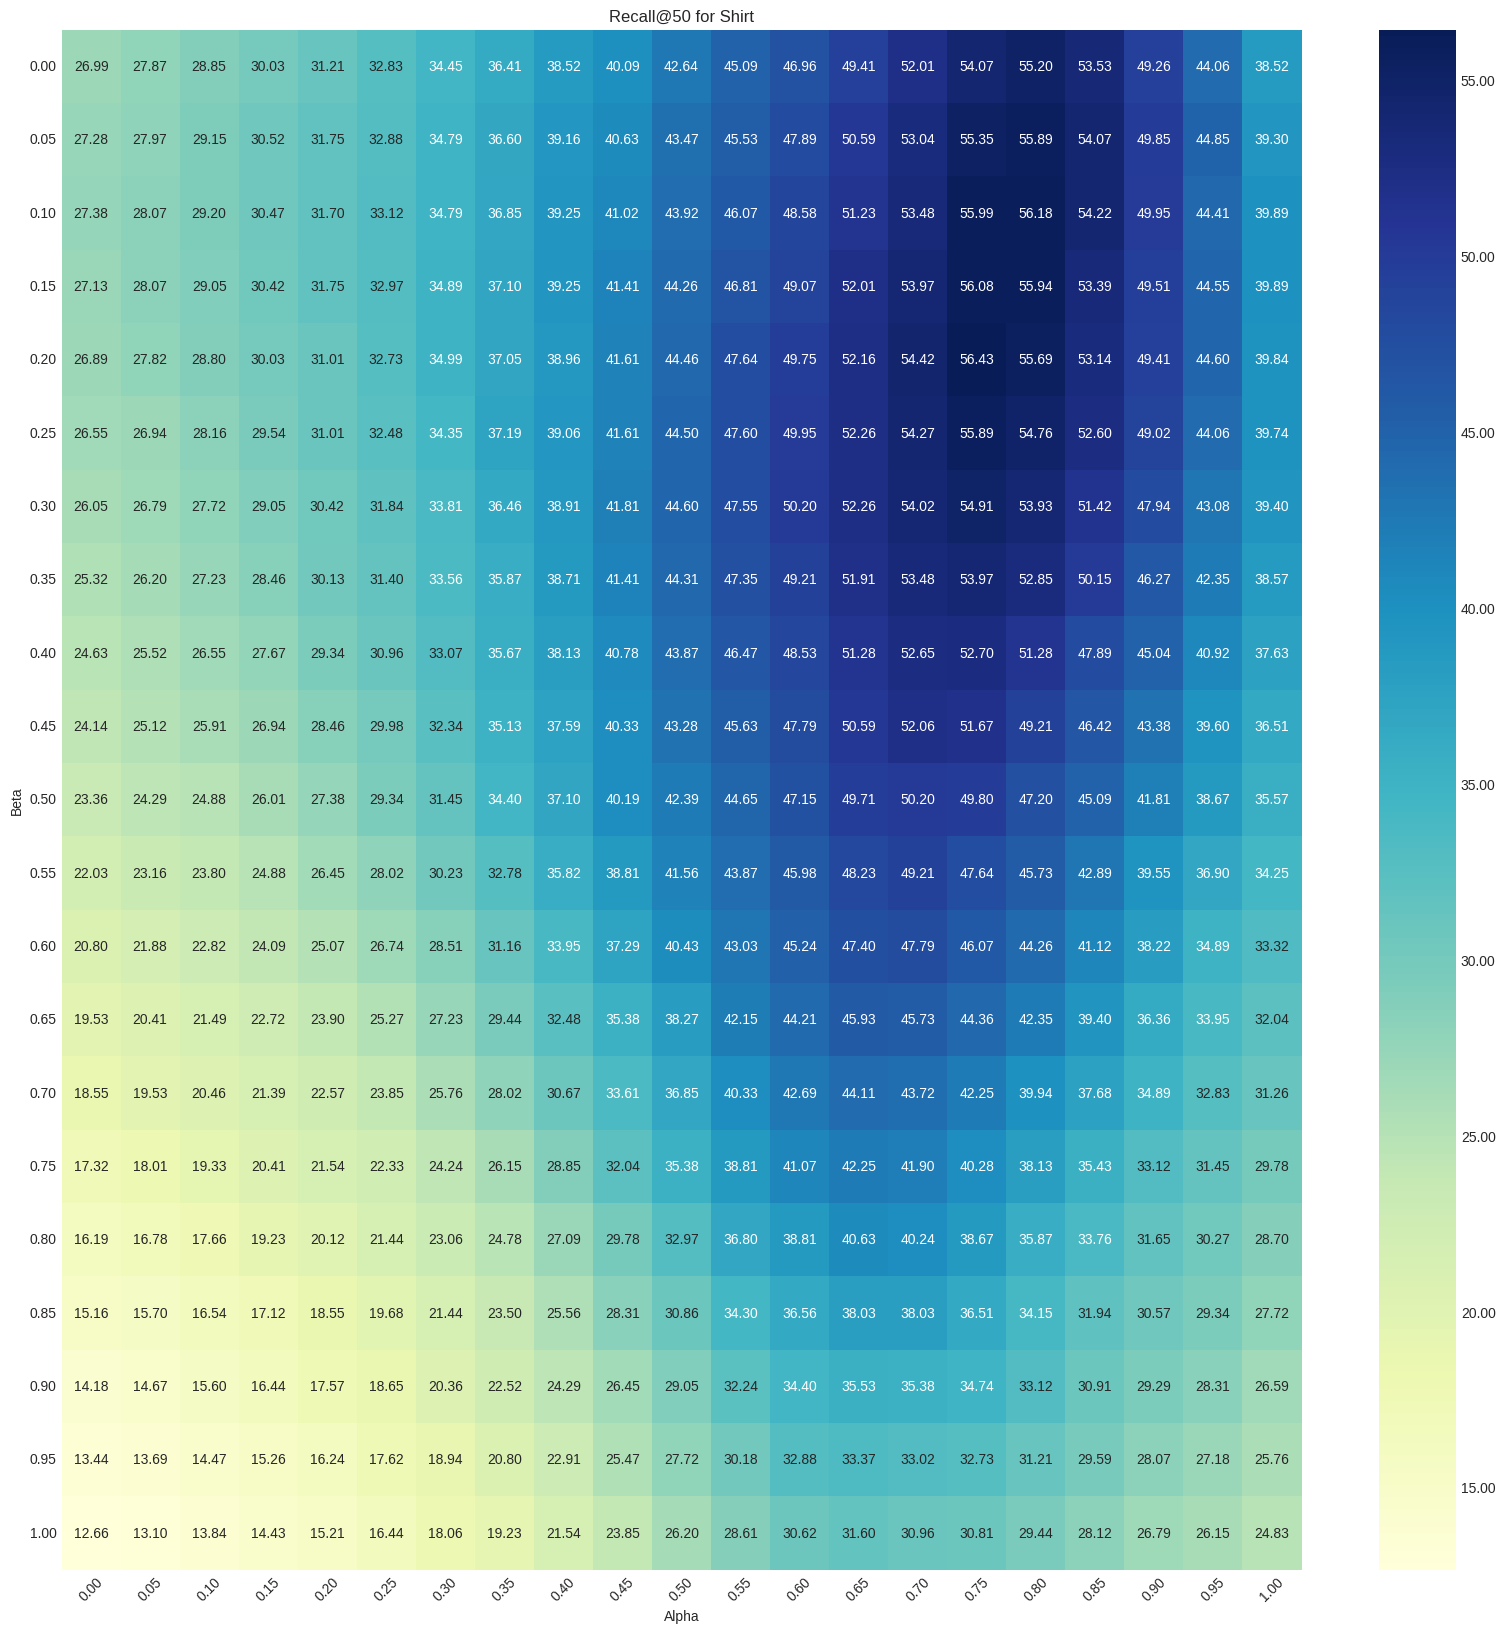

In [23]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

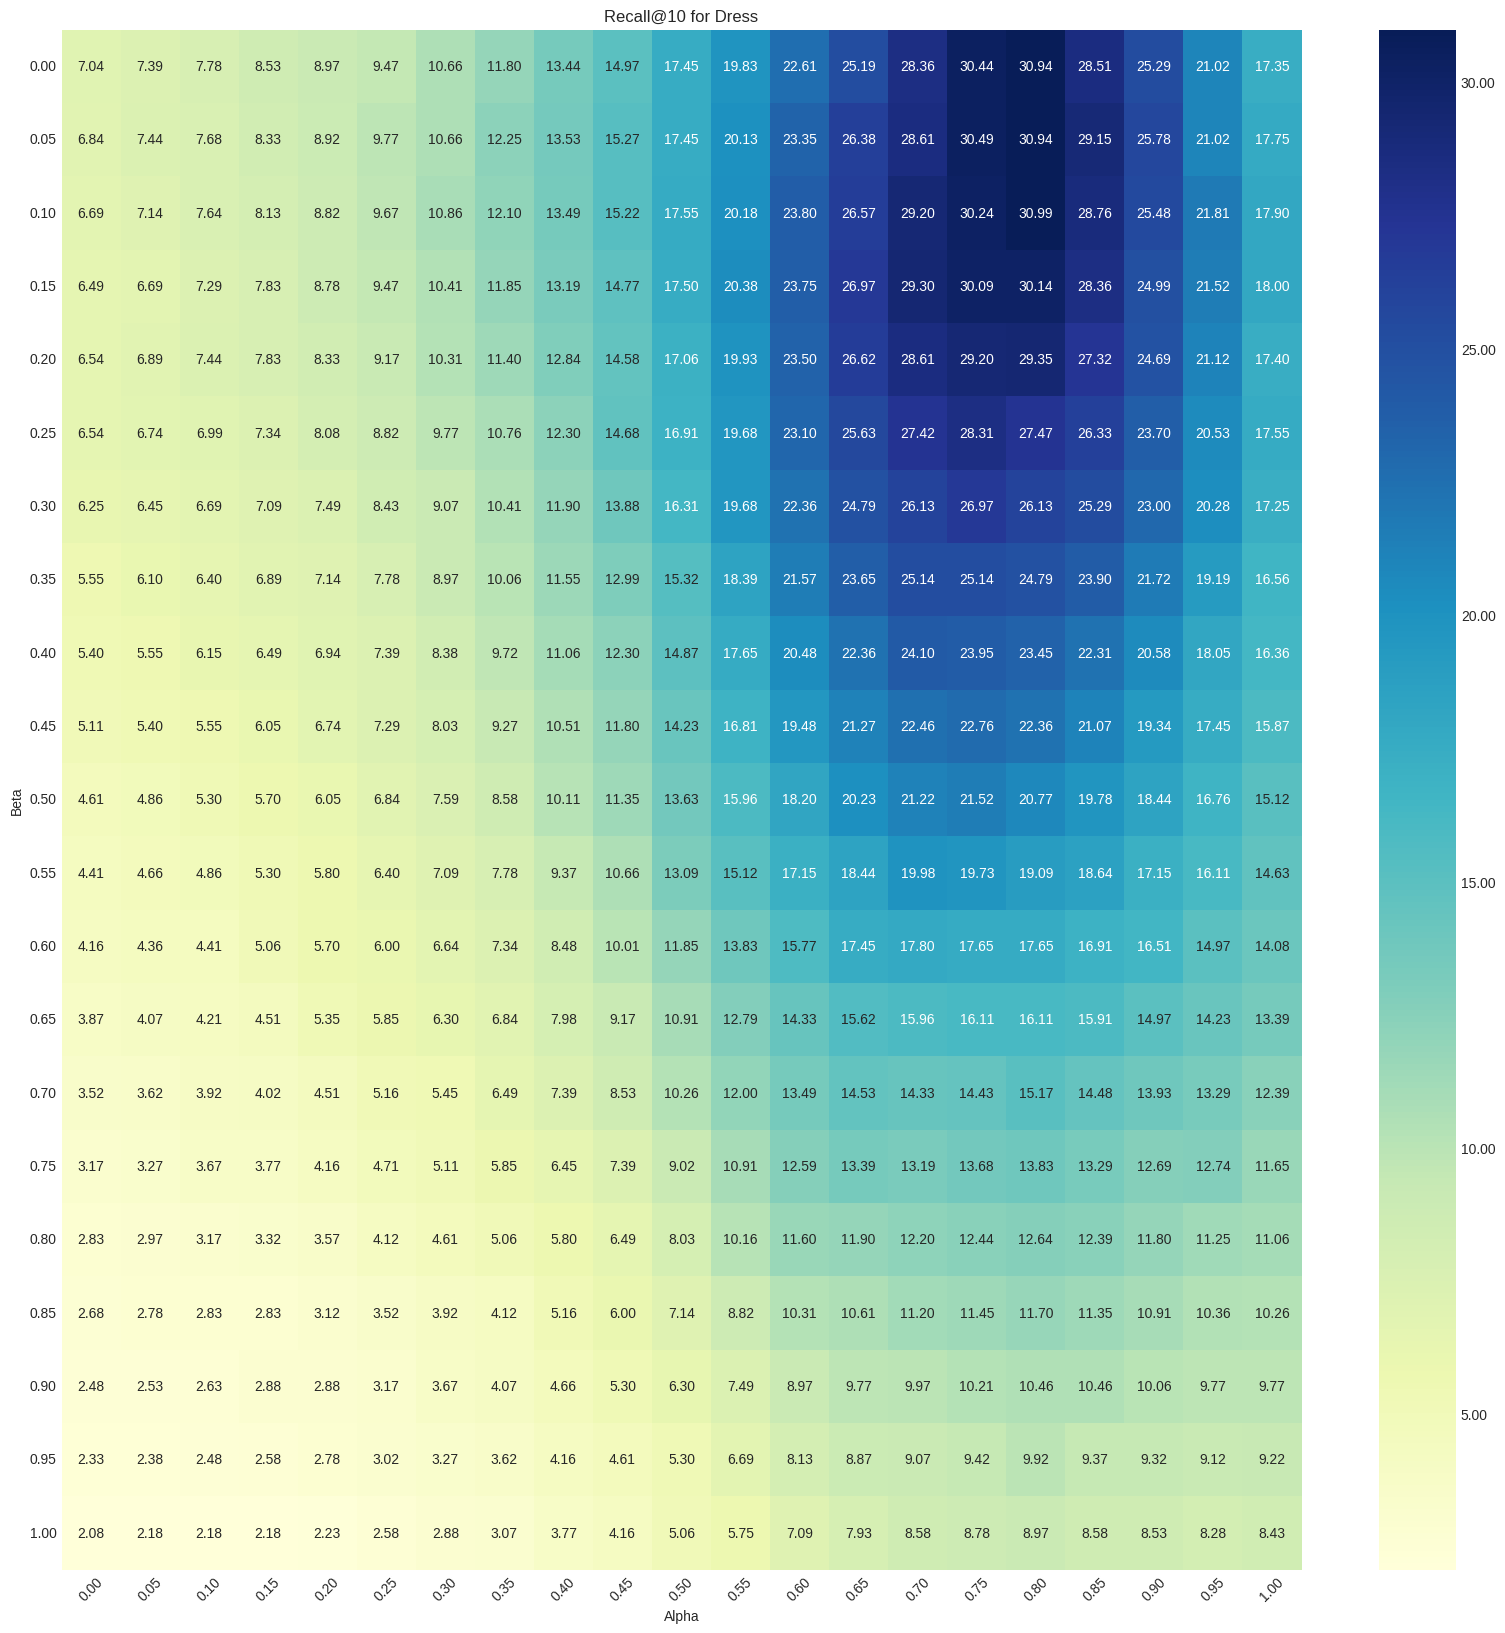

In [24]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

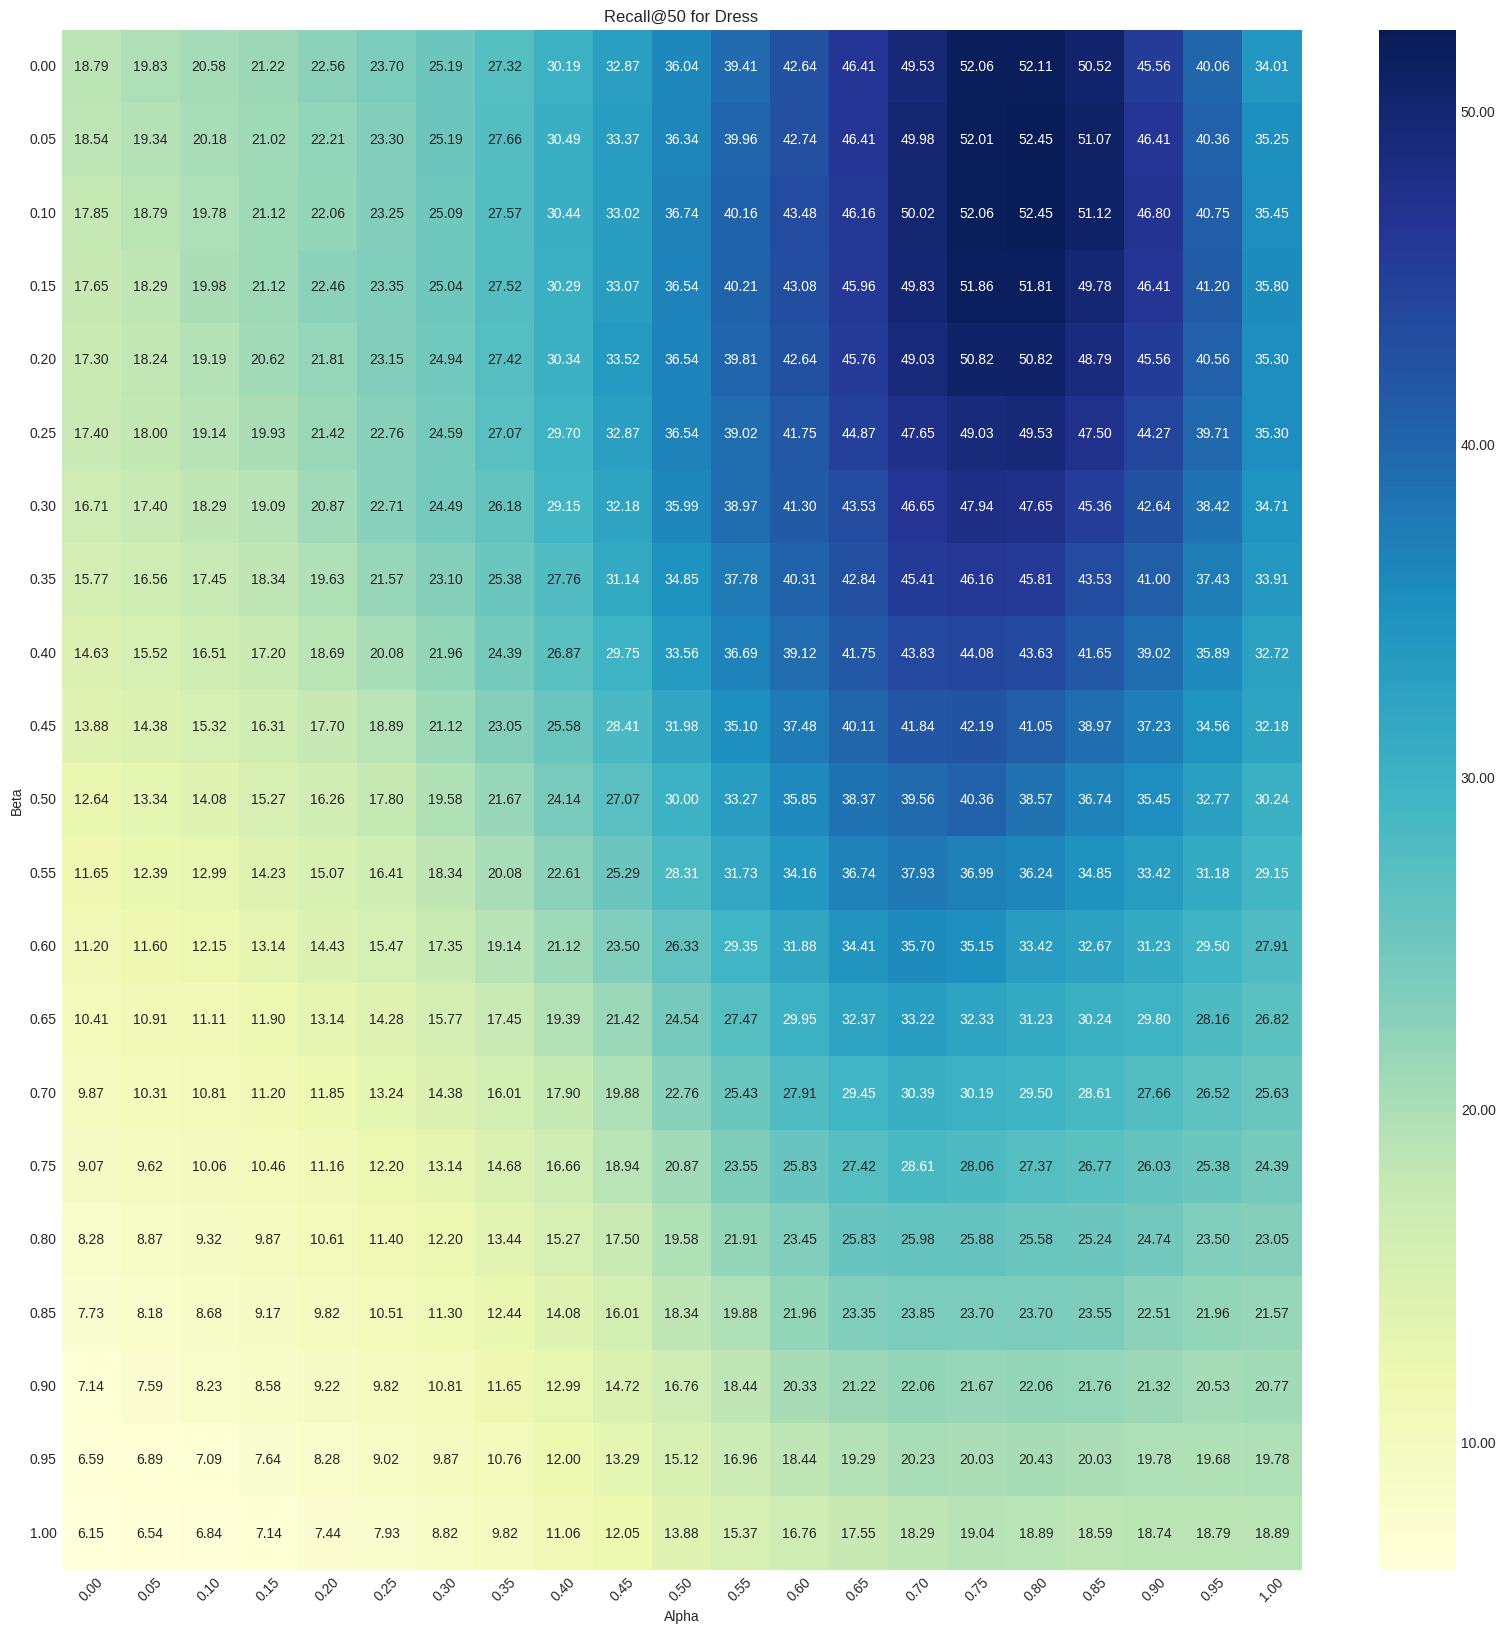

In [25]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

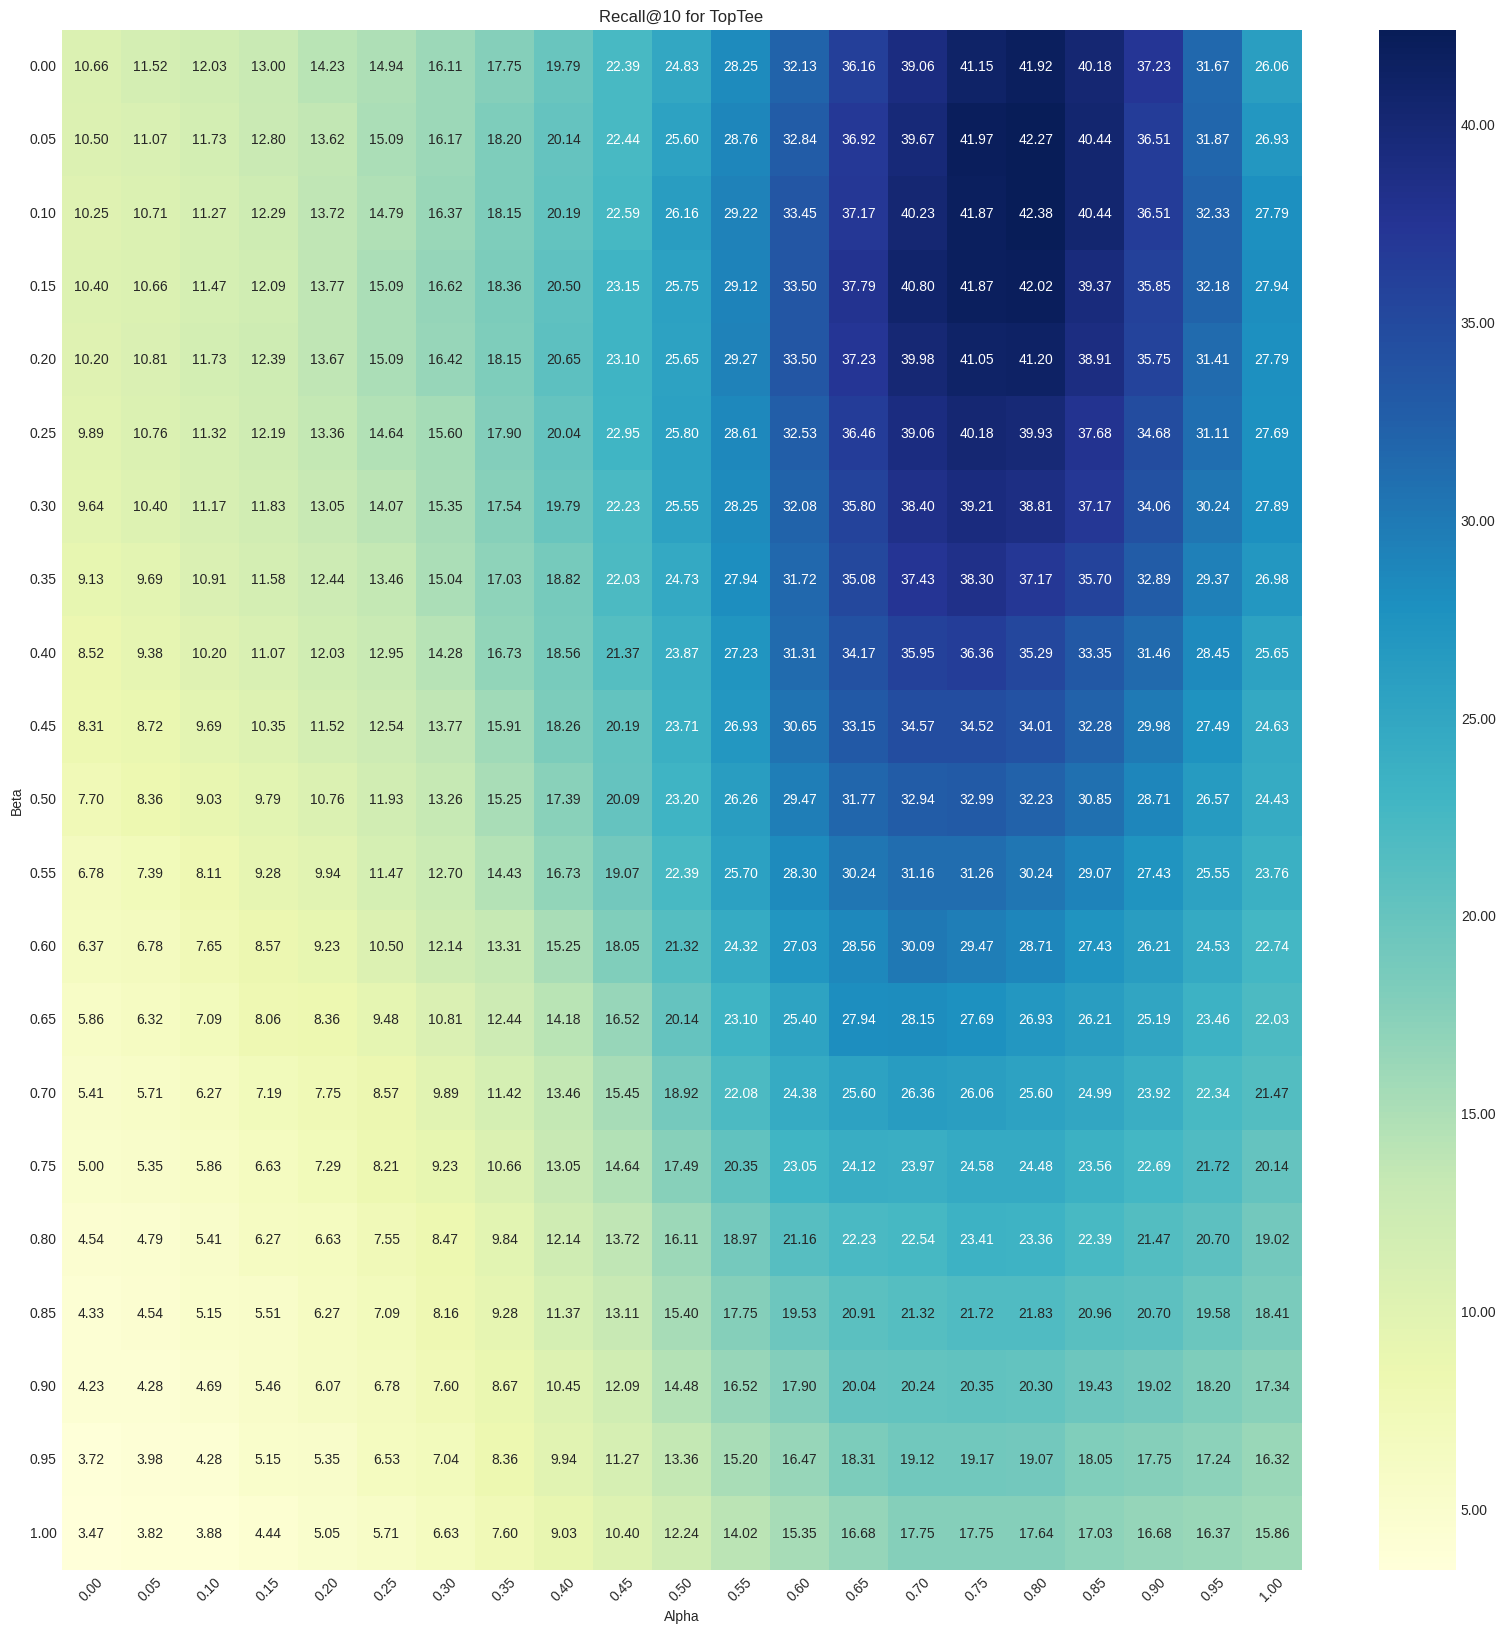

In [26]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

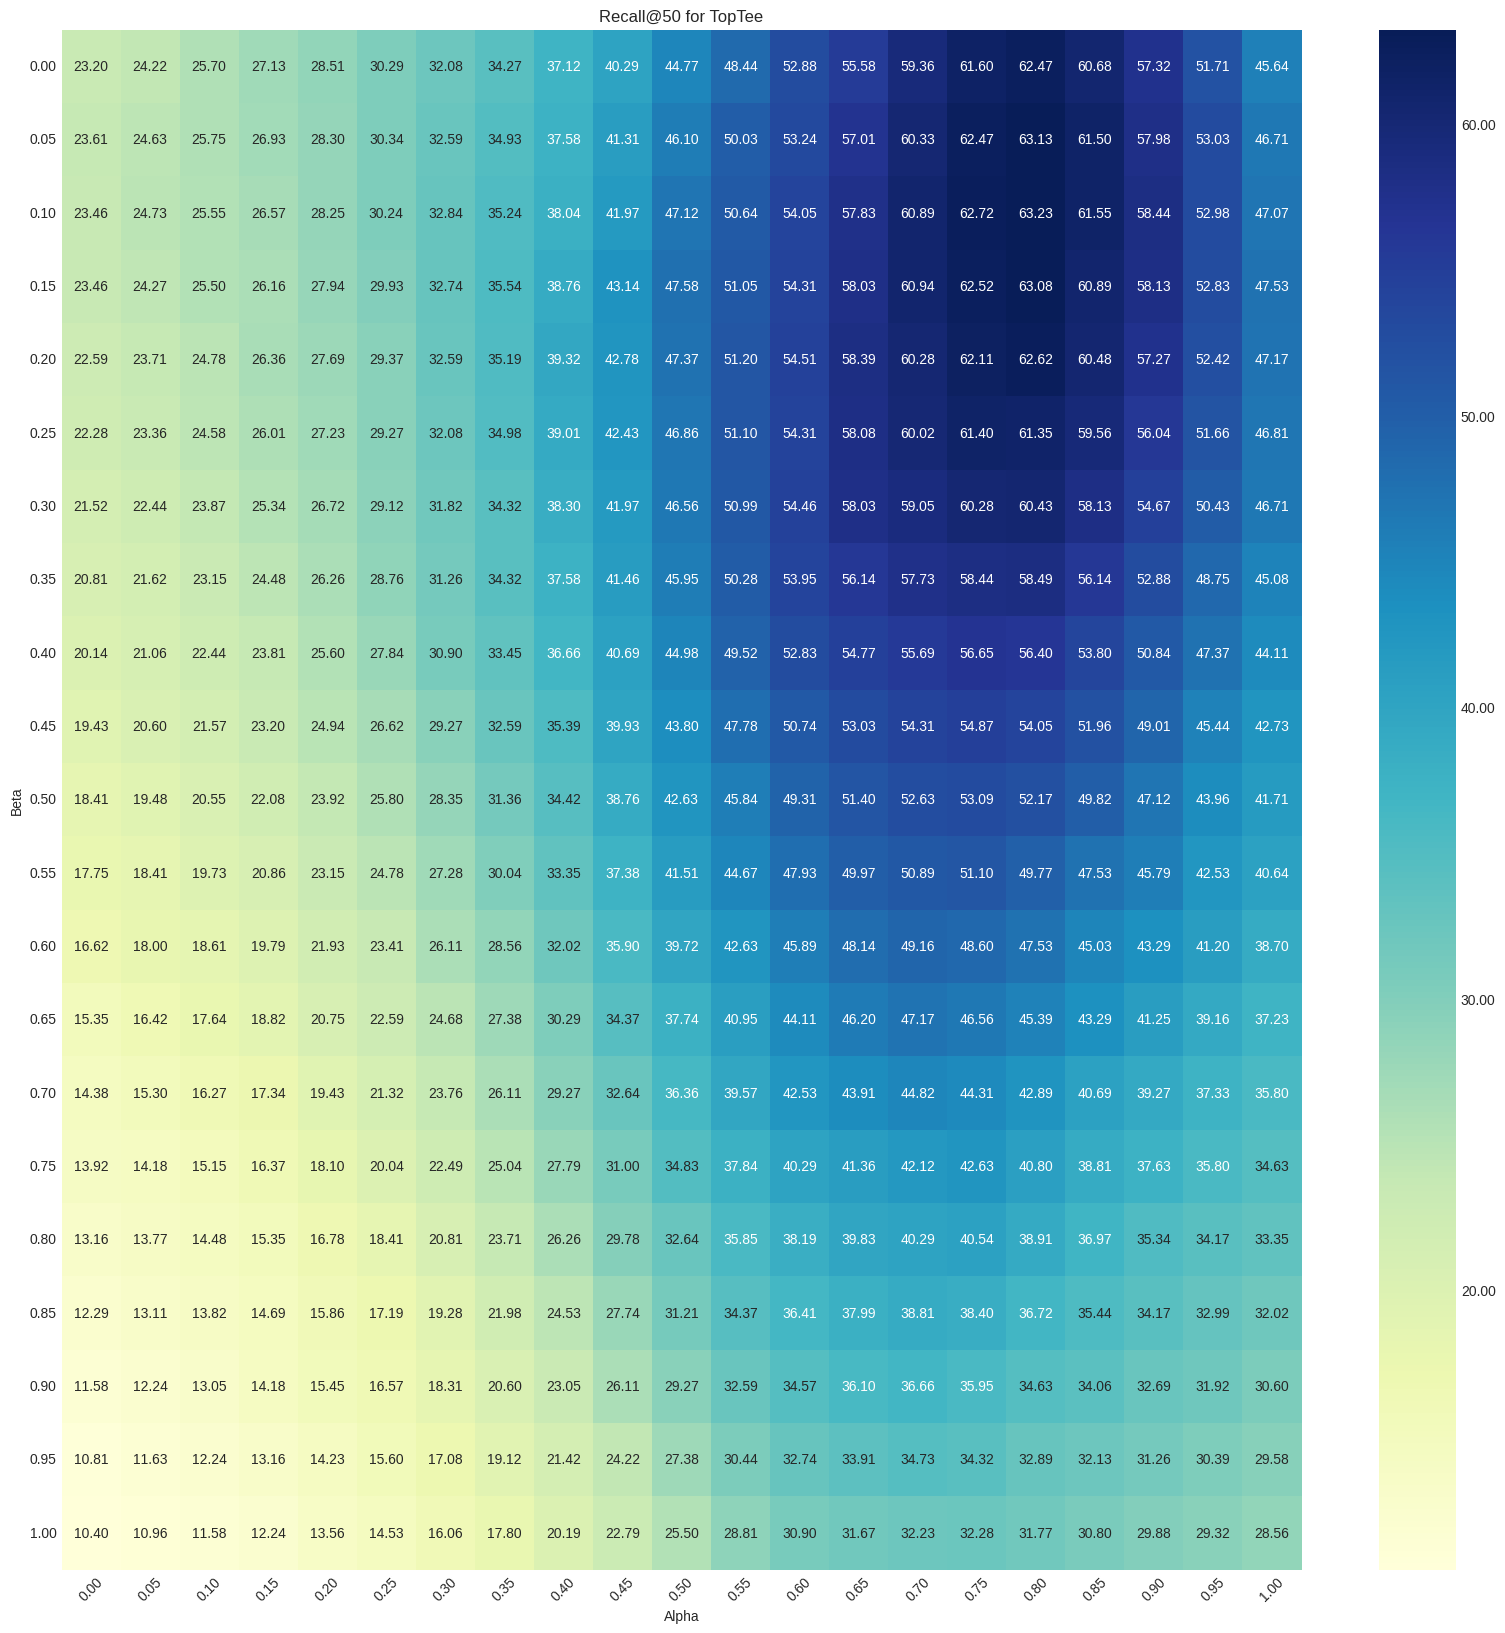

In [27]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

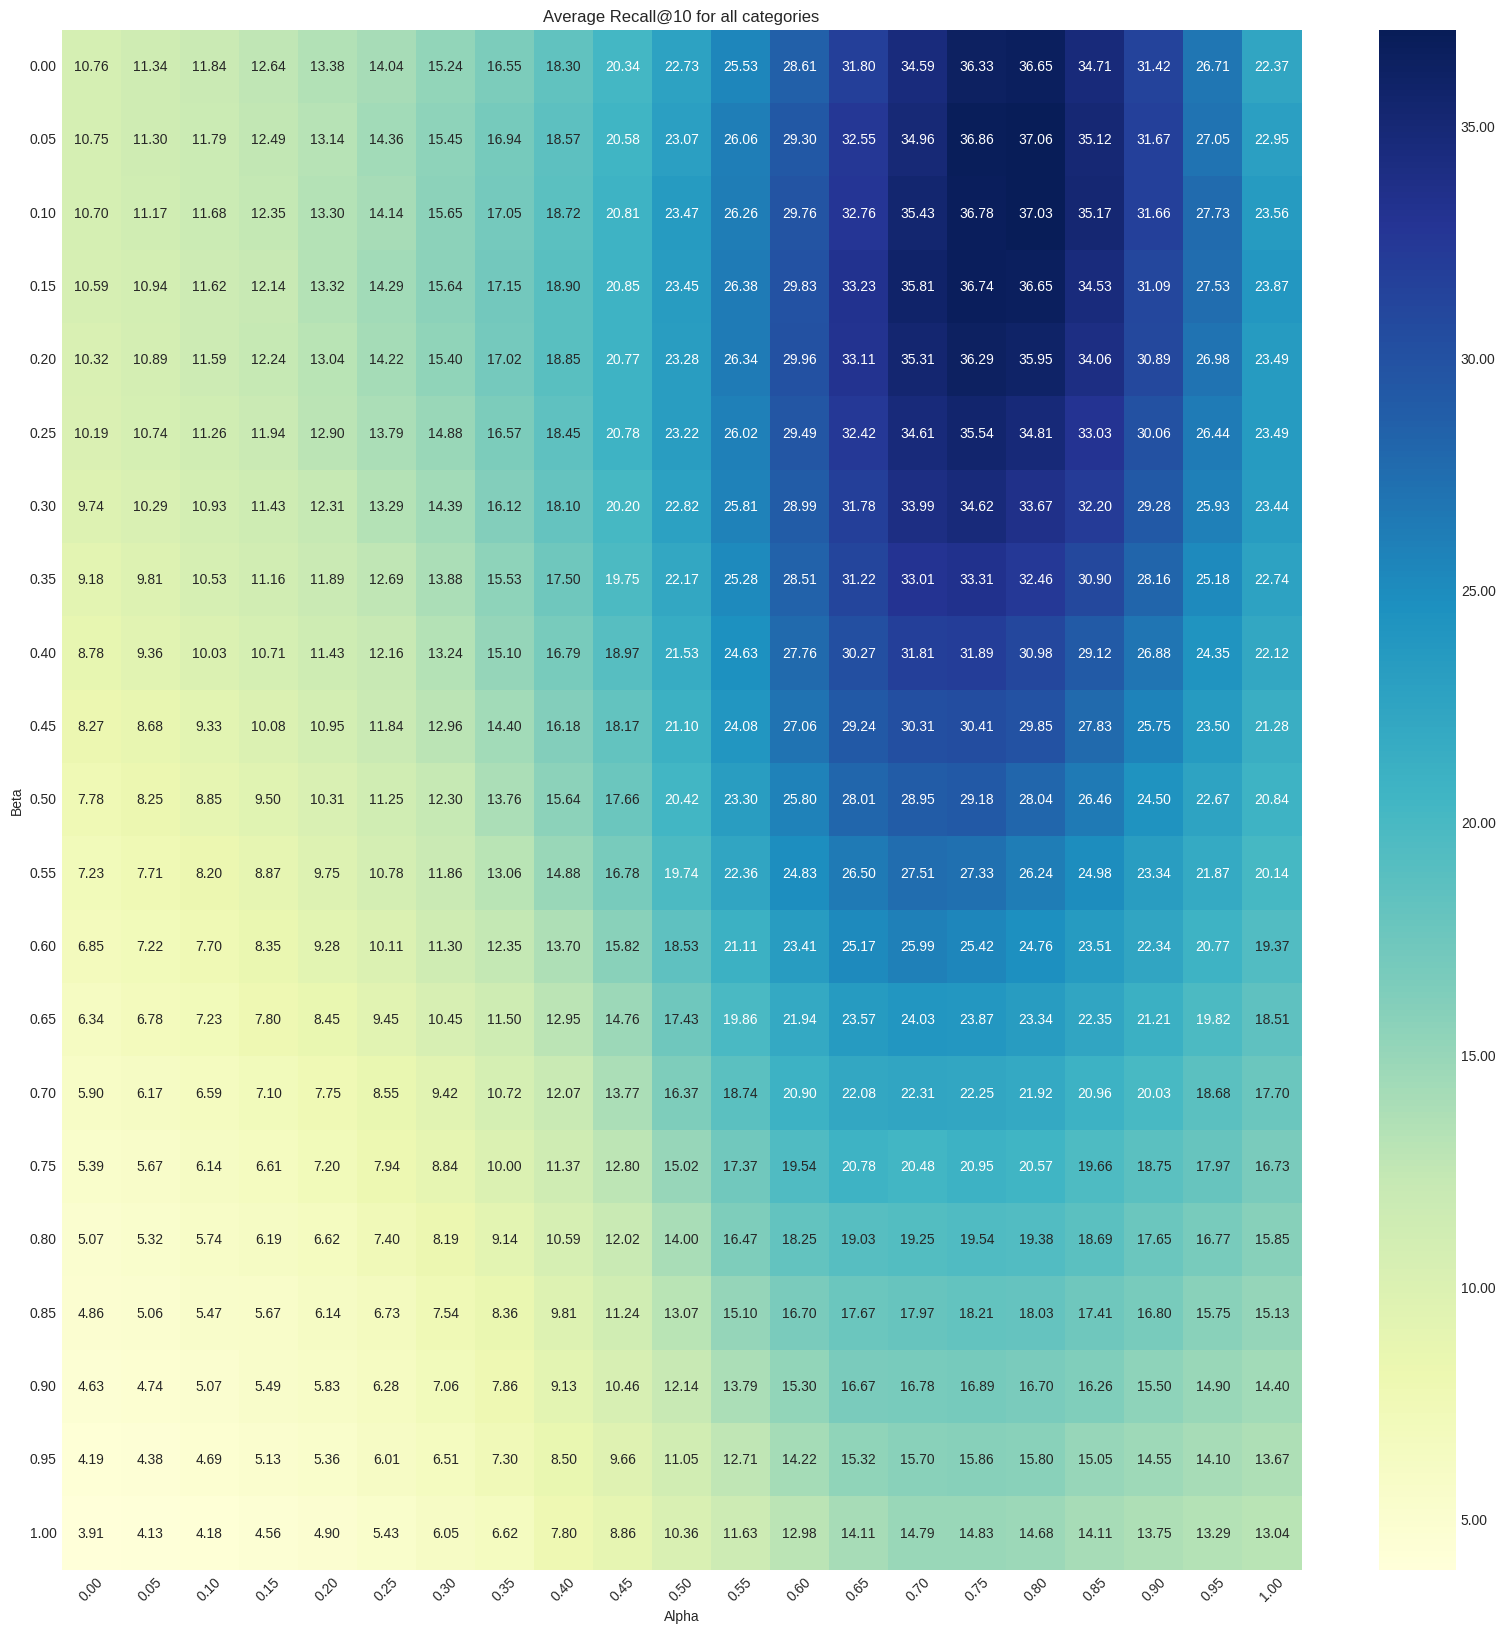

In [28]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

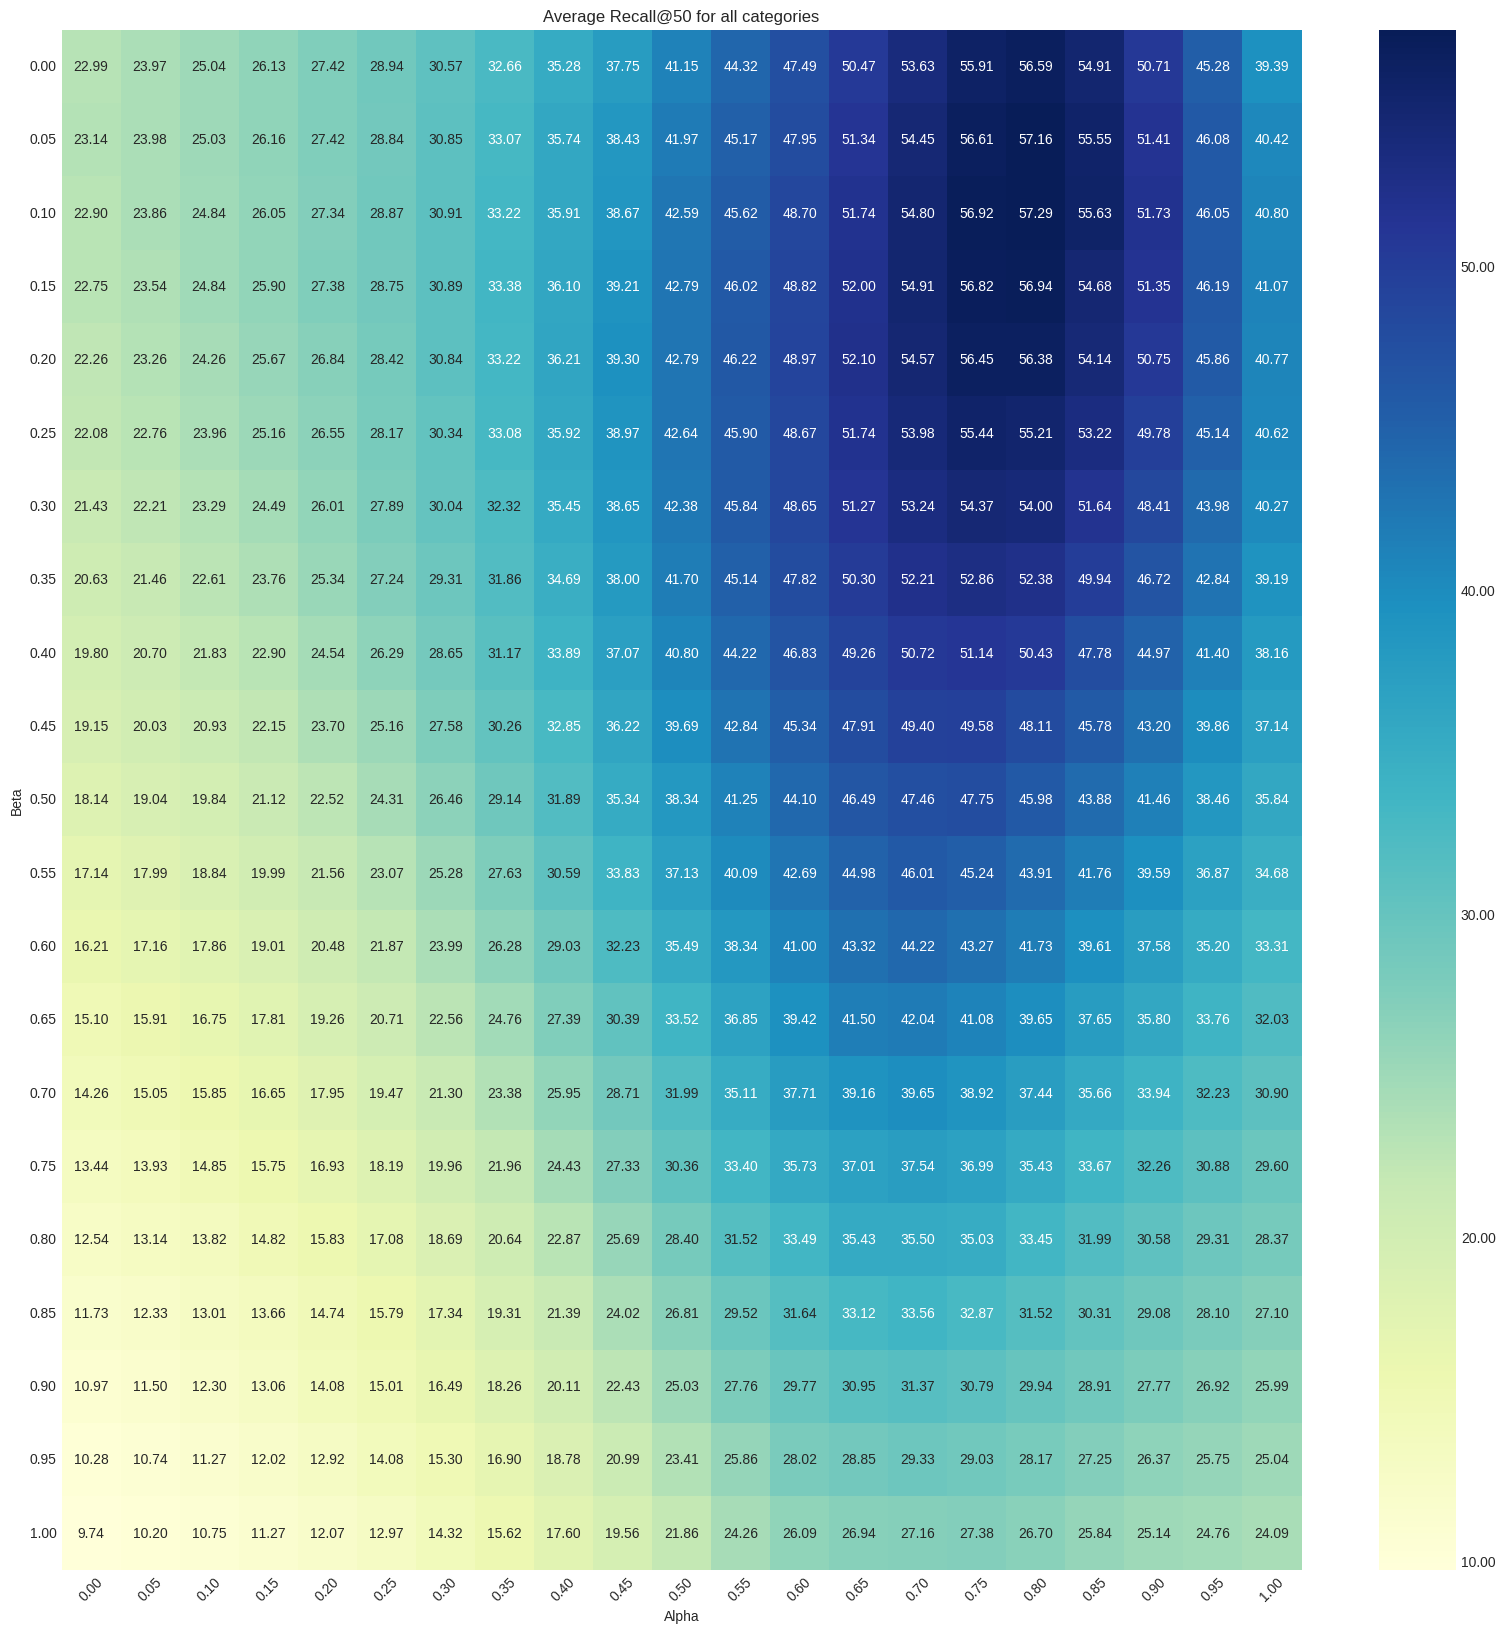

In [29]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [30]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val_clip(
    'shirt',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 37.73307204246521
Recall at 50: 56.182533502578735


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [31]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val_clip(
    'dress',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 30.986613035202026
Recall at 50: 52.45413780212402


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [32]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val_clip(
    'toptee',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 42.37633943557739
Recall at 50: 63.233041763305664


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [33]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

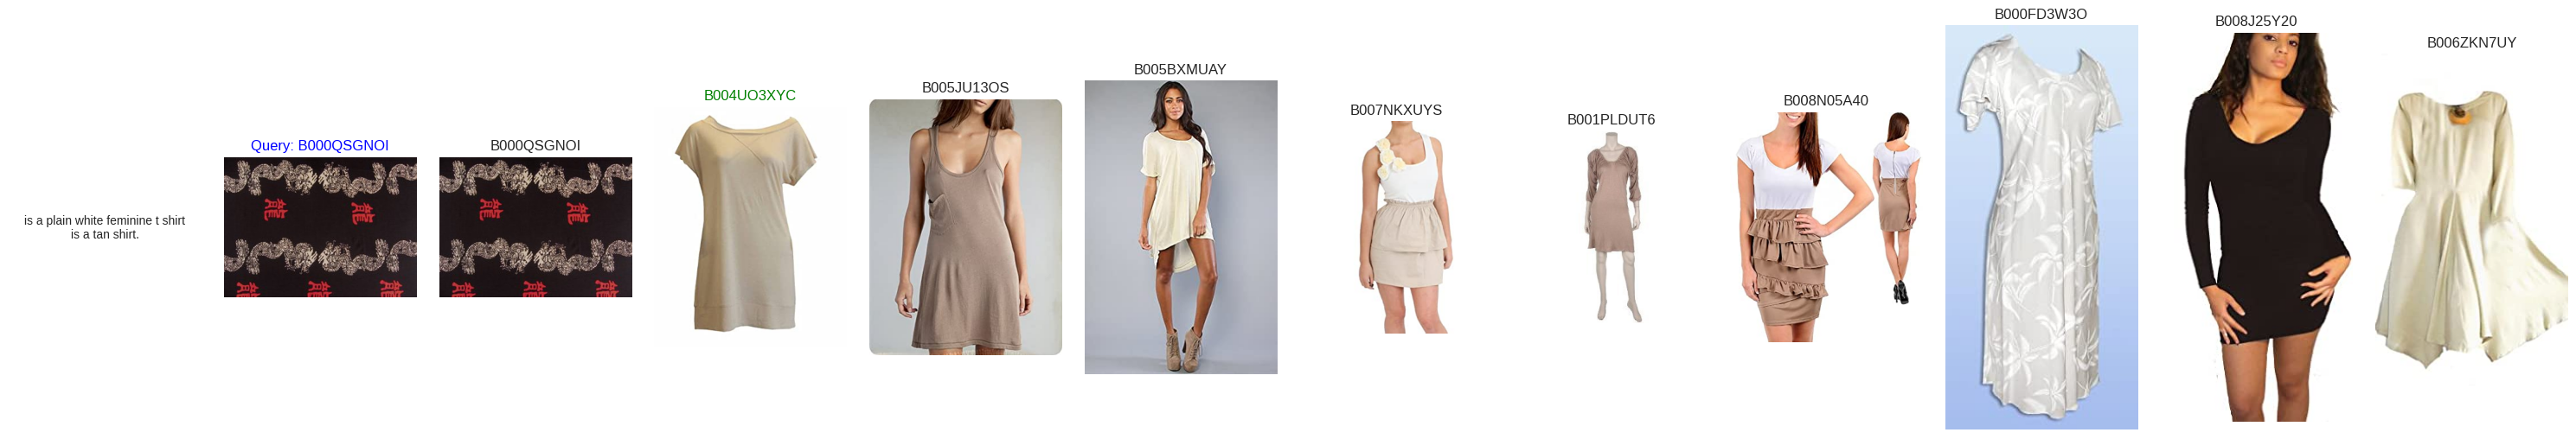

In [34]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [35]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val_clip(
    'shirt',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 25.90775191783905
Recall at 50: 42.63984262943268


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [36]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val_clip(
    'dress',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 17.451660335063934
Recall at 50: 36.04362905025482


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [37]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val_clip(
    'toptee',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 24.834267795085907
Recall at 50: 44.773074984550476


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [38]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(335, [13, 16, 20, 21, 26, 34, 40, 45, 49, 50])

In [39]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(87, [10, 75, 123, 222, 258, 276, 281, 287, 289, 376])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [40]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(337, [0, 1, 3, 12, 16, 26, 32, 38, 40, 43])

In [41]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(69, [23, 114, 126, 159, 176, 215, 298, 340, 345, 378])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [42]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(429, [7, 9, 10, 15, 16, 17, 20, 21, 25, 26])

In [43]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(76, [35, 57, 101, 112, 216, 238, 263, 342, 398, 403])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

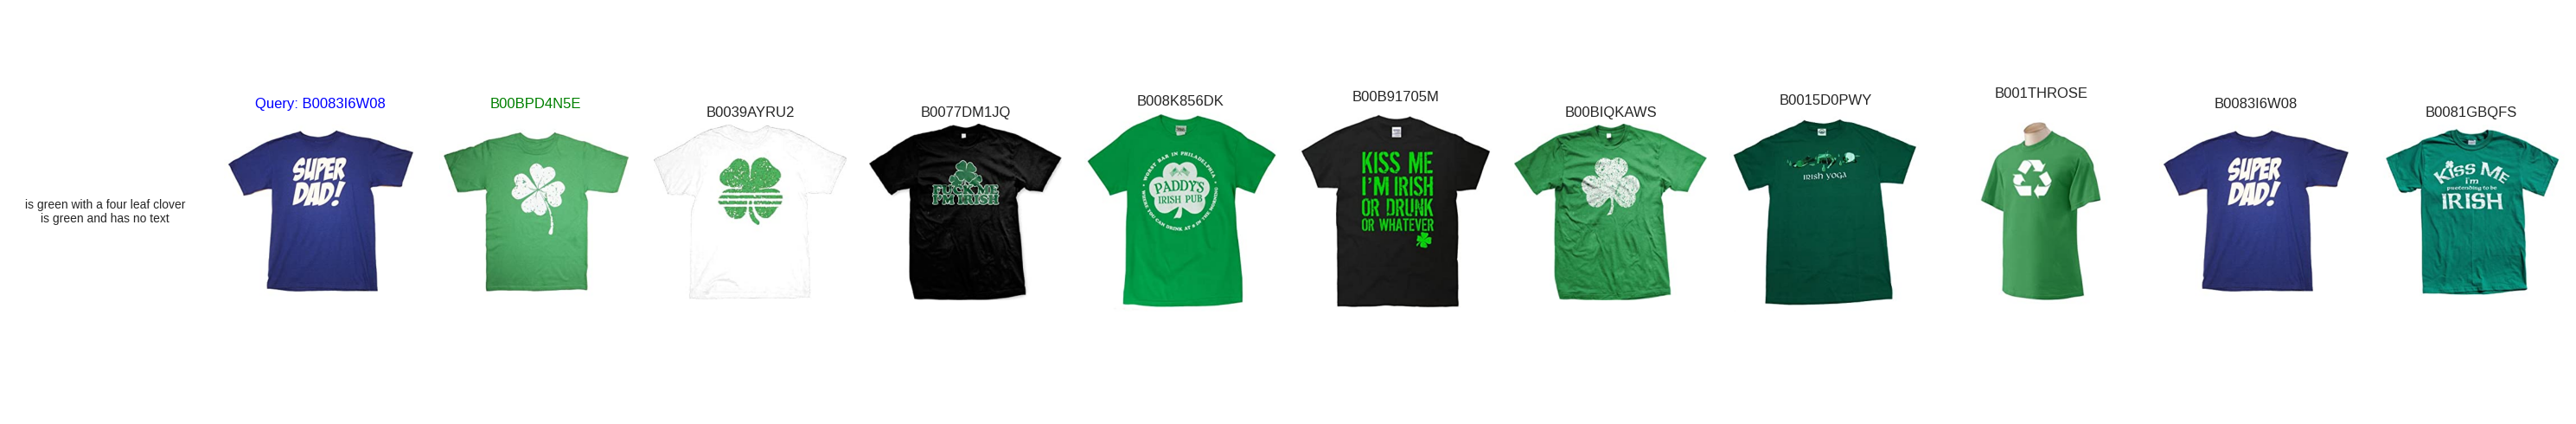

In [44]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

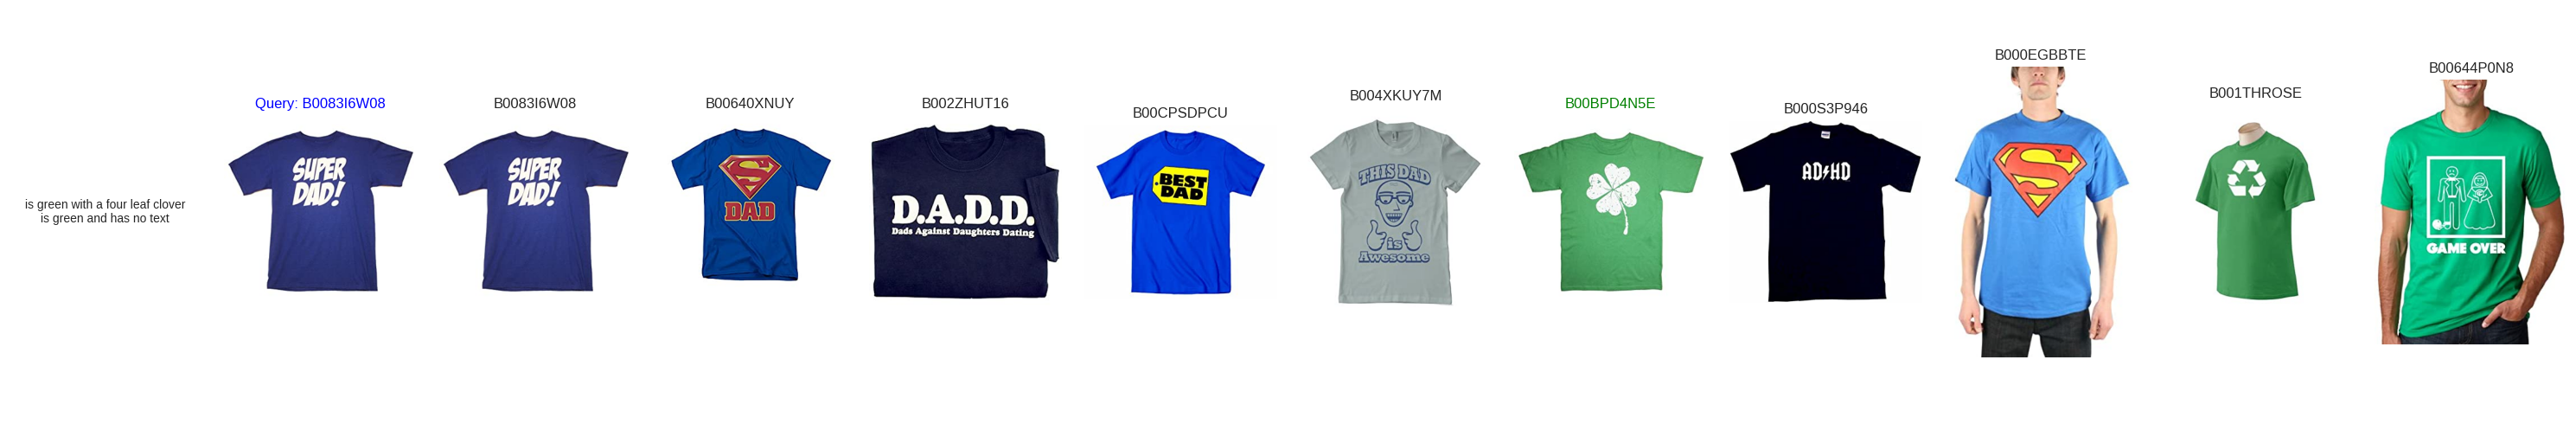

In [45]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

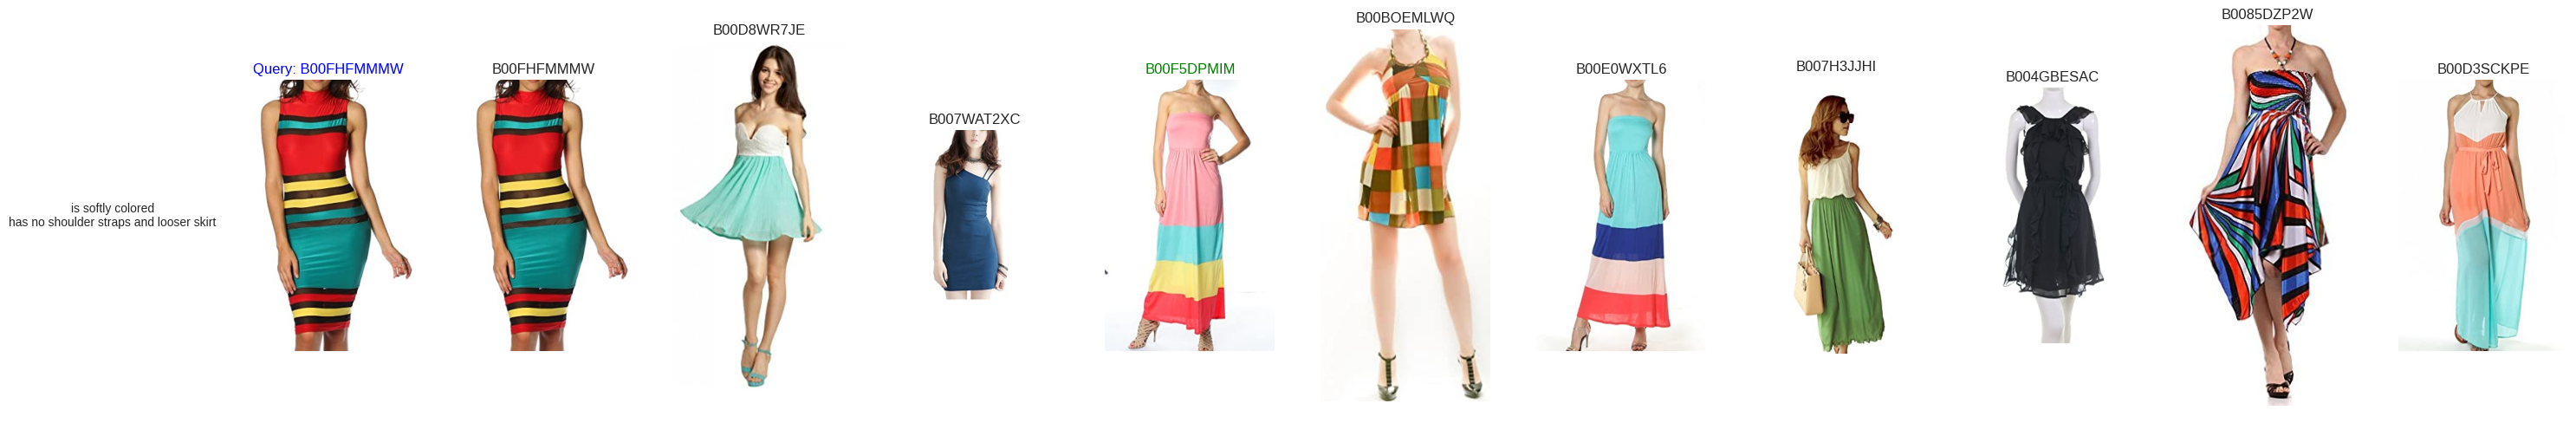

In [46]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

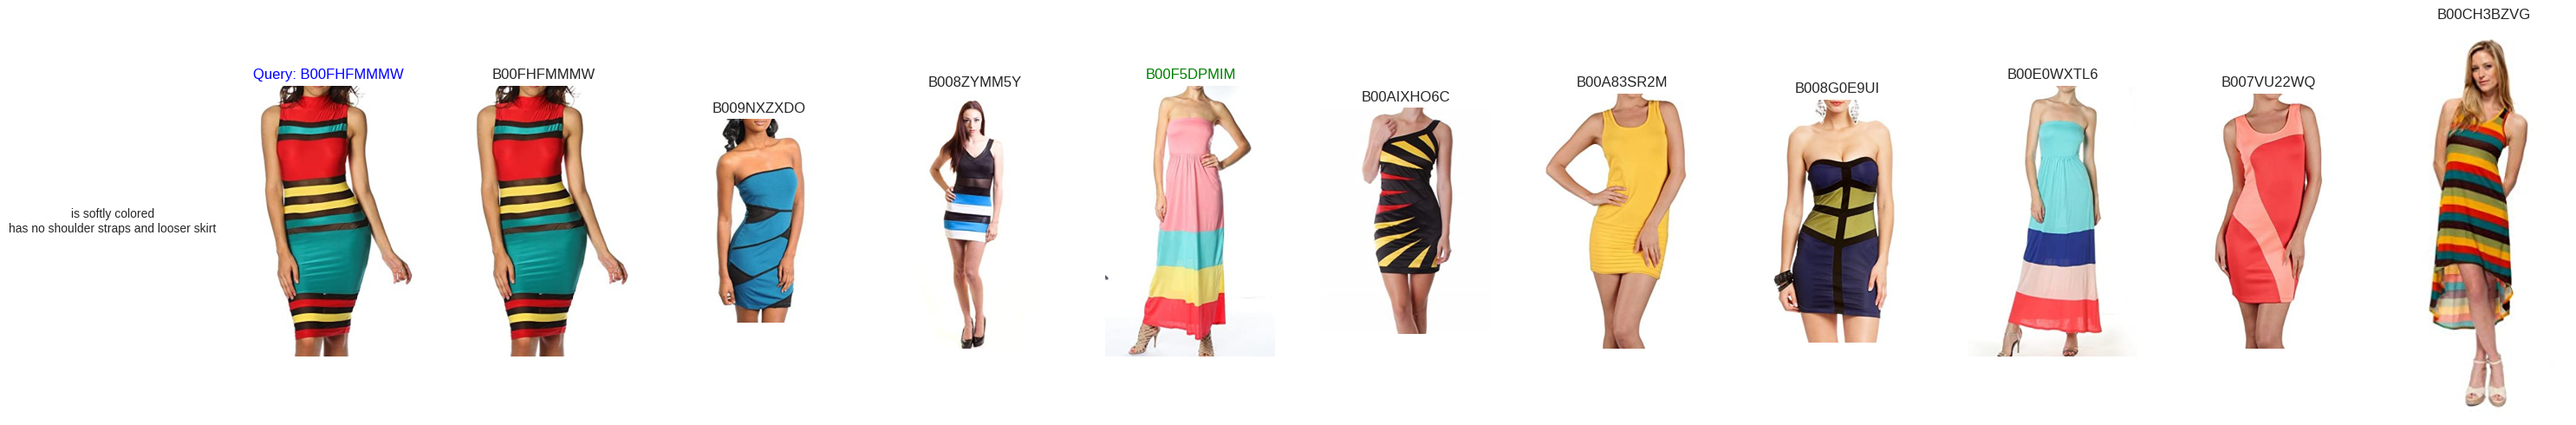

In [47]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

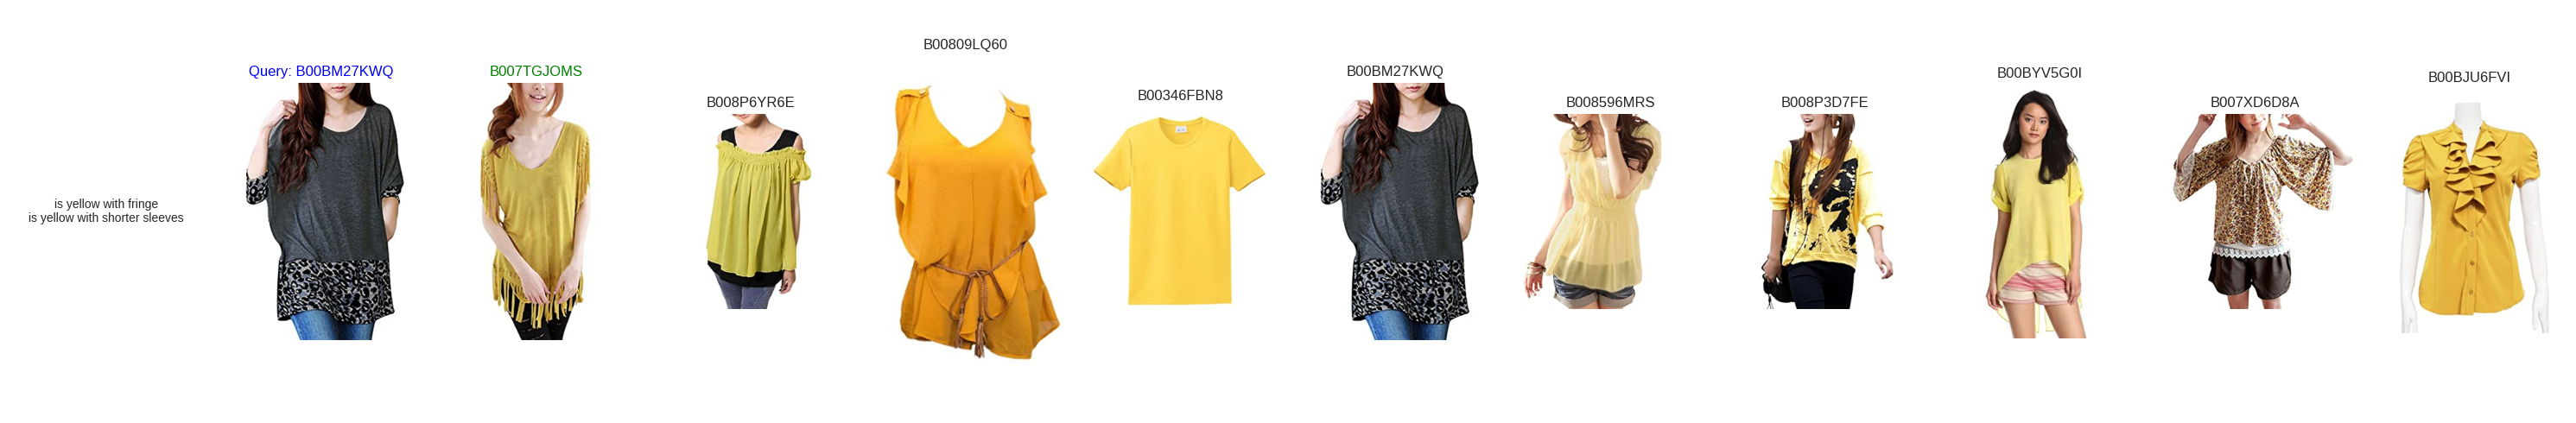

In [48]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

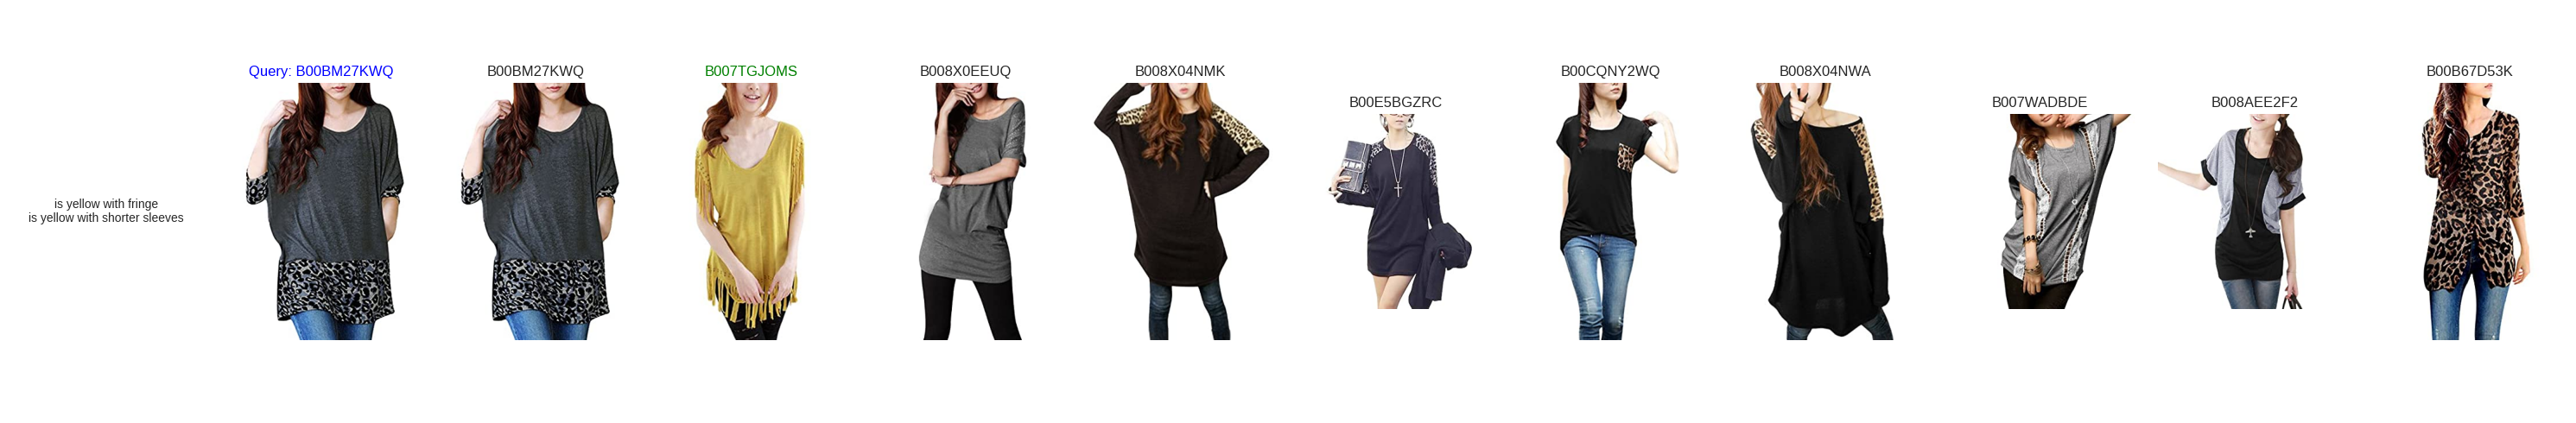

In [49]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8: Save the results for plotting</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">This is used for better adjust visualization for report</div>

In [50]:
average_recall_at10.to_csv('average_recall_at10_clip_vit_g14_laion.csv')
average_recall_at50.to_csv('average_recall_at50_clip_vit_g14_laion.csv')